In [1]:
import csv
import pandas as pd
import os
import numpy as np

In [2]:
# reading the dataset
df_original = pd.read_excel("Flight_Data\Flight_Ticket_Participant_Datasets\Data_Train.xlsx")
df_original.describe()

Price
count  10683.000000
mean    9087.064121
std     4611.359167
min     1759.000000
25%     5277.000000
50%     8372.000000
75%    12373.000000
max    79512.000000

In [3]:
# preprocess for the columns that have date/times
# split into hours, minutes and timedelta object
# happens in columns Date_of_Journey , Dep_Time, Arrival_Time
def preprocess_dates_dataframe(df):
    
    
    #df["Period"] = df[["Courses", "Duration"]].apply("-".join, axis=1)
    
    #concatenate date of journey and departure time columns
    df['dep_datetime'] = df[["Date_of_Journey", "Dep_Time"]].apply(" ".join, axis=1)
    
    #convert the date column to a datetime object
    df['dep_datetime'] = pd.to_datetime(df['dep_datetime'], format='%d/%m/%Y %H:%M')
    
    #split Duration column into hours and minutes and remove last character ('h'/'m')
    df[['duration_hours', 'duration_minutes']] = df['Duration'].str.split(' ', expand=True)
    df['duration_hours'] = df['duration_hours'].str.slice(stop=-1)
    df['duration_minutes'] = df['duration_minutes'].str.slice(stop=-1)
    
    #after this process, durations with no minute specifications say None. We will edit the dataframe to replace
    #them with 0 in the minutes column using fillna
    df['duration_minutes'] = df['duration_minutes'].fillna("0")
    
    # Concatenate the two columns duration_minutes and duration_hours and 
    #Convert the timedelta_duraction column to a timedelta object
    df['timedelta_duration'] = df[['duration_hours', 'duration_minutes']].apply(":".join, axis=1)
    df['timedelta_duration'] = pd.to_timedelta(df['Duration'])
    
    #add the two columns to produce the arrival date in a datetime object
    df['arr_datetime'] = df['dep_datetime'] + df['timedelta_duration']

    
    #drop unnecessary columns
    #Date_of_Journey, Dep_Time: Replaced by dep_datetime
    #Duration, timedelta_duration: Replaced by duration_hours and duration_minutes
    #Arrival_Time: Replaced by arr_datetime because in some records it was inaccurate (time-travel)

    #df = df.drop(['Date_of_Journey', 'Dep_Time', 'Duration', 'timedelta_duration', 'Arrival_Time'], axis=1)
    
    print(df.columns)
    print(df.shape)
    #print(df.loc[15,['dep_datetime', 'Duration', 'timedelta_duration', 'arr_datetime']])
    
    return df

df_processed_dates = preprocess_dates_dataframe(df_original)

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'dep_datetime', 'duration_hours',
       'duration_minutes', 'timedelta_duration', 'arr_datetime'],
      dtype='object')
(10683, 16)


In [4]:
#add population of departure and arrival cities to enrich our dataset
#found from https://statisticstimes.com/demographics/country/india-cities-population.php
def add_population_columns(df):
    df_population = pd.read_excel("Auxiliary_Data\indian_cities_population.xlsx")
    df_population.set_index('City', inplace=True)
    
    dict_pop = df_population.to_dict()
    #print(dict_pop)
    
    source_popu_list = list()
    dest_popu_list = list()
    
    print(df)
    
    #Iterate through the dataframe rows for 'Source' and 'Destination'
    for index, row in df.iterrows():
        source = row['Source']
        destination = row['Destination']
        
        source_popu_list.append(dict_pop['Population_2020'][source])
        dest_popu_list.append(dict_pop['Population_2020'][destination])
    
    df['Departure_City_Population'] = source_popu_list
    df['Arrival_City_Population'] = dest_popu_list
    
    return df

df_temp = add_population_columns(df_processed_dates)
print(df_processed_dates[['Source','Departure_City_Population','Destination','Arrival_City_Population']])
    

           Airline Date_of_Journey    Source Destination  \
0           IndiGo      24/03/2019  Banglore   New Delhi   
1        Air India       1/05/2019   Kolkata    Banglore   
2      Jet Airways       9/06/2019     Delhi      Cochin   
3           IndiGo      12/05/2019   Kolkata    Banglore   
4           IndiGo      01/03/2019  Banglore   New Delhi   
...            ...             ...       ...         ...   
10678     Air Asia       9/04/2019   Kolkata    Banglore   
10679    Air India      27/04/2019   Kolkata    Banglore   
10680  Jet Airways      27/04/2019  Banglore       Delhi   
10681      Vistara      01/03/2019  Banglore   New Delhi   
10682    Air India       9/05/2019     Delhi      Cochin   

                       Route Dep_Time  Arrival_Time Duration Total_Stops  \
0                  BLR → DEL    22:20  01:10 22 Mar   2h 50m    non-stop   
1      CCU → IXR → BBI → BLR    05:50         13:15   7h 25m     2 stops   
2      DEL → LKO → BOM → COK    09:25  04:25 10 Jun

<h2>Exploring the dataset in its current form (Visualization)</h2>


In [5]:
print(df_processed_dates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   Airline                    10683 non-null  object         
 1   Date_of_Journey            10683 non-null  object         
 2   Source                     10683 non-null  object         
 3   Destination                10683 non-null  object         
 4   Route                      10682 non-null  object         
 5   Dep_Time                   10683 non-null  object         
 6   Arrival_Time               10683 non-null  object         
 7   Duration                   10683 non-null  object         
 8   Total_Stops                10682 non-null  object         
 9   Additional_Info            10683 non-null  object         
 10  Price                      10683 non-null  int64          
 11  dep_datetime               10683 non-null  datetime64[

<p>As we can see, there is a lot of categorical data (Airline, Source, Destination, Additional_Info). Are these columns related to the Price of the ticket? What is the distribution of these categorical values?</p>


<h4>Countplots for categorigal columns</h4>


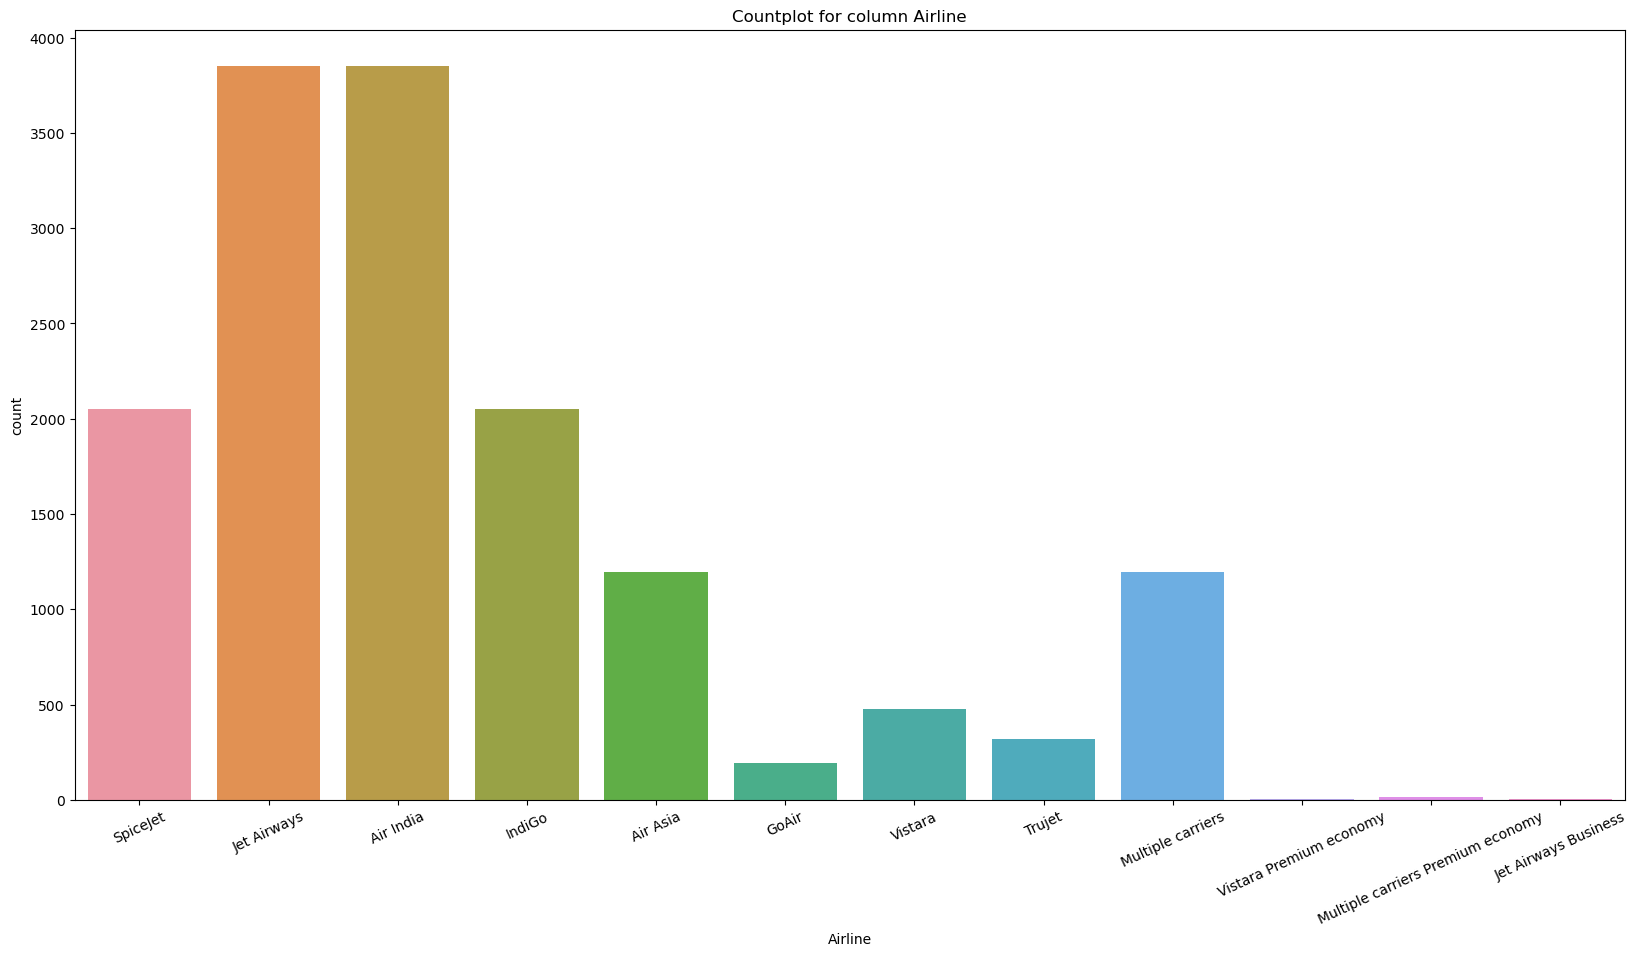

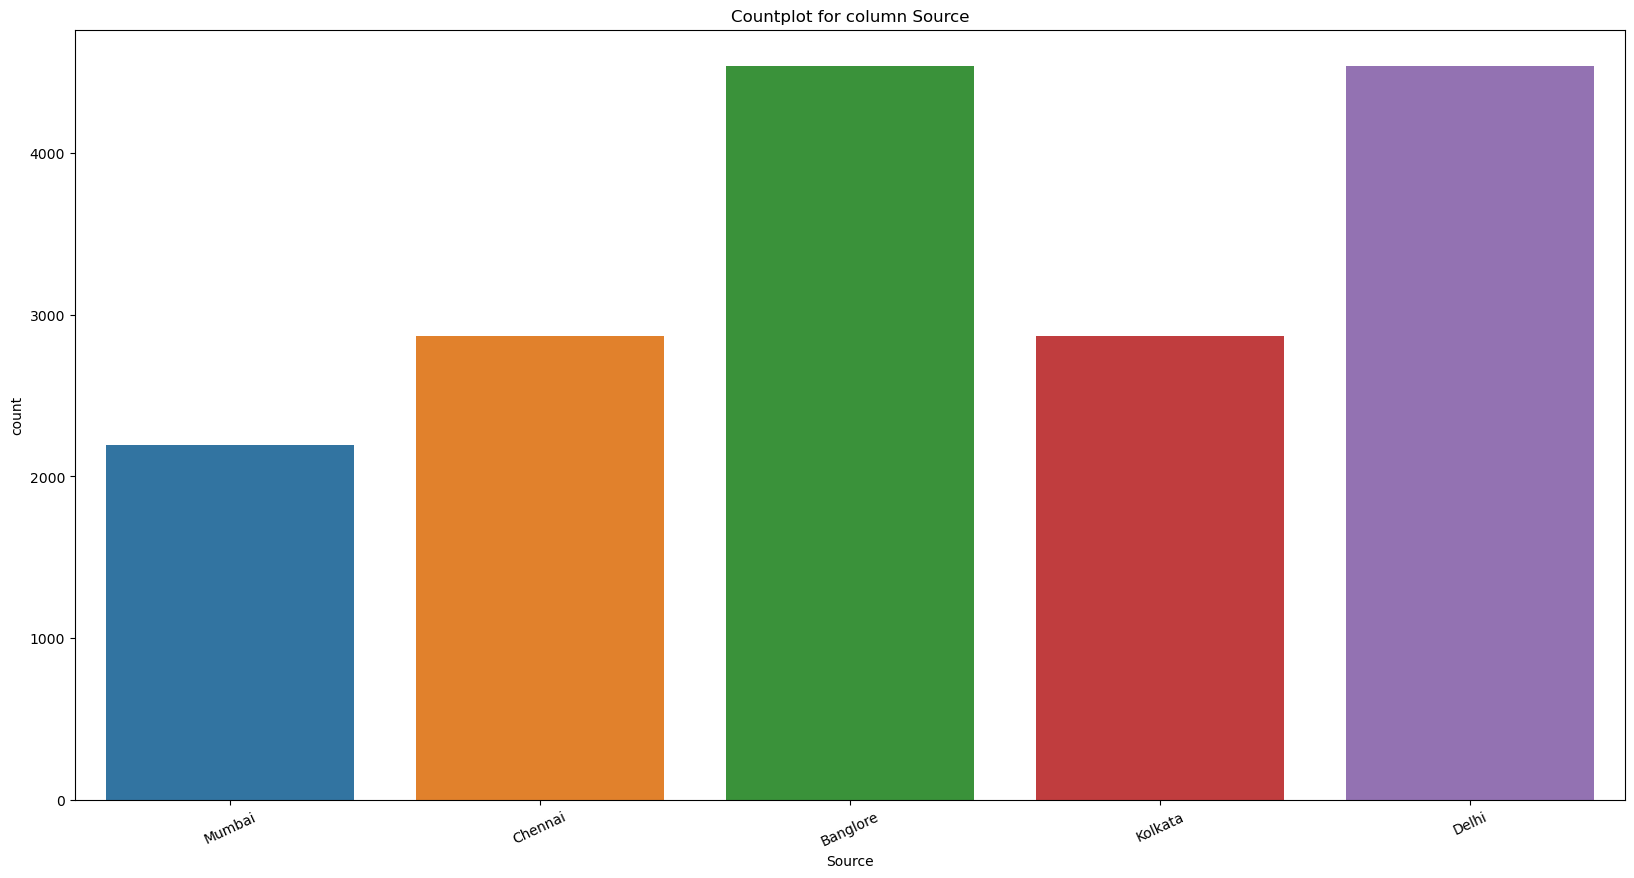

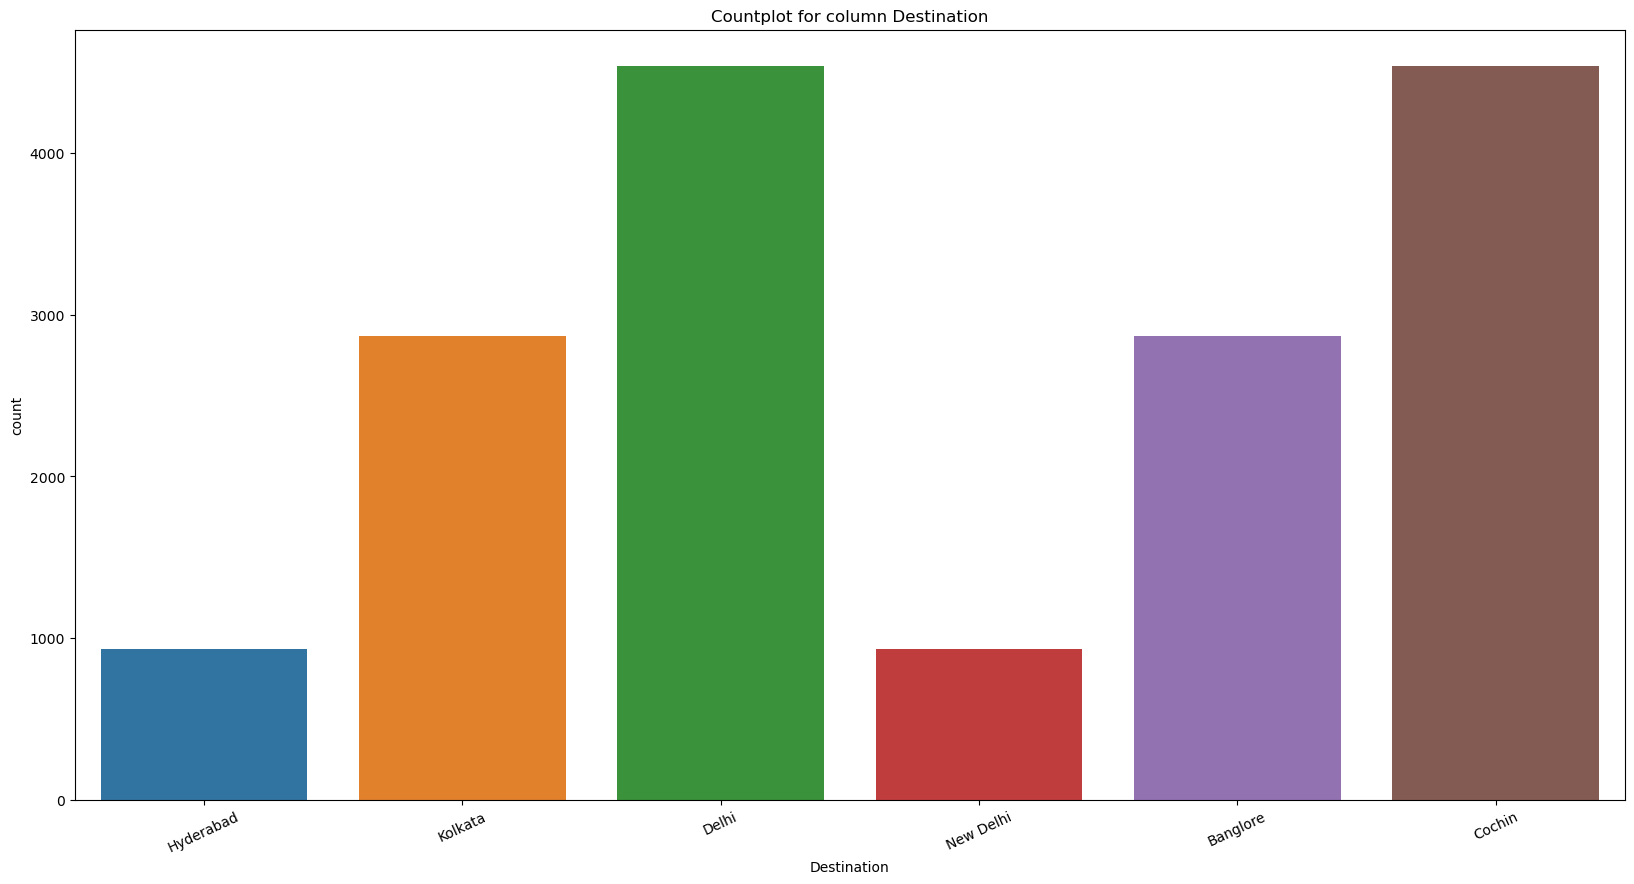

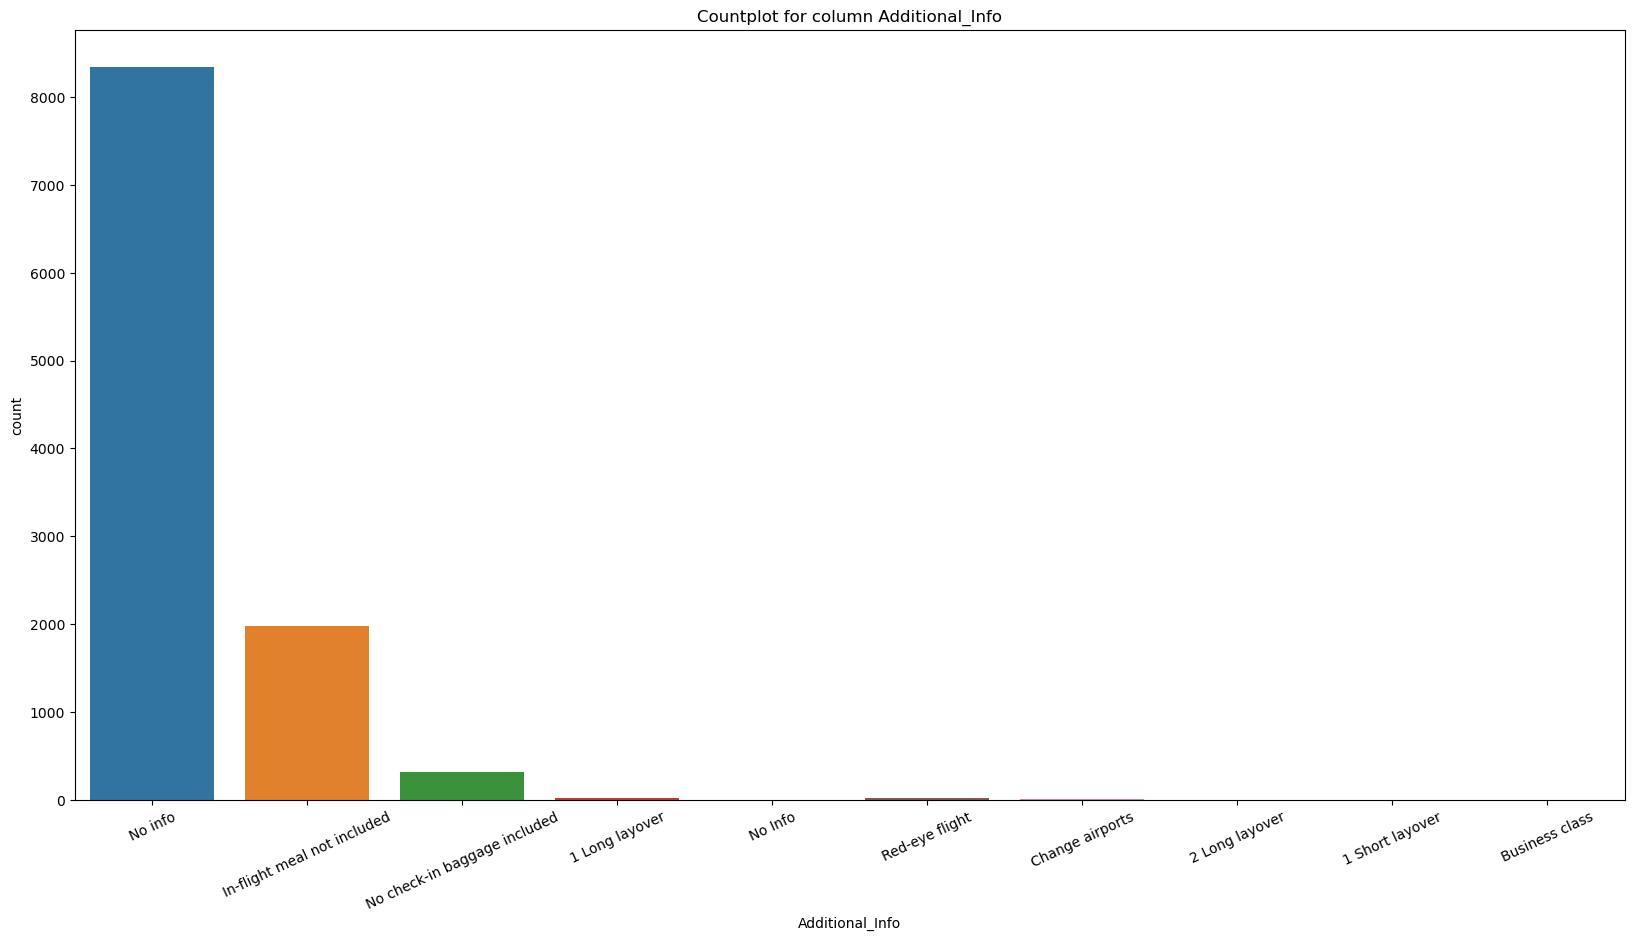

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in ['Airline', 'Source', 'Destination', 'Additional_Info']:
    plt.figure(figsize = (20,10))
    sns.countplot(data = df_processed_dates, x = column)
    ax = sns.countplot(x = column, data = df_processed_dates.sort_values('Price', ascending = True))
    ax.set_title(f"Countplot for column {column}")
    #rotate the labels 25
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 25)
    plt.savefig(f"vis\\countplot_{column}.png")
    plt.show()



<p>From the above plots, the one that stands out is the plot for Additional_Info, which shows that most entries in the dataset have the value No Info in that column. This is an indicator for us that this column might not prove too useful for our model.</p>


<h4>Box plots for categorical columns</h4>


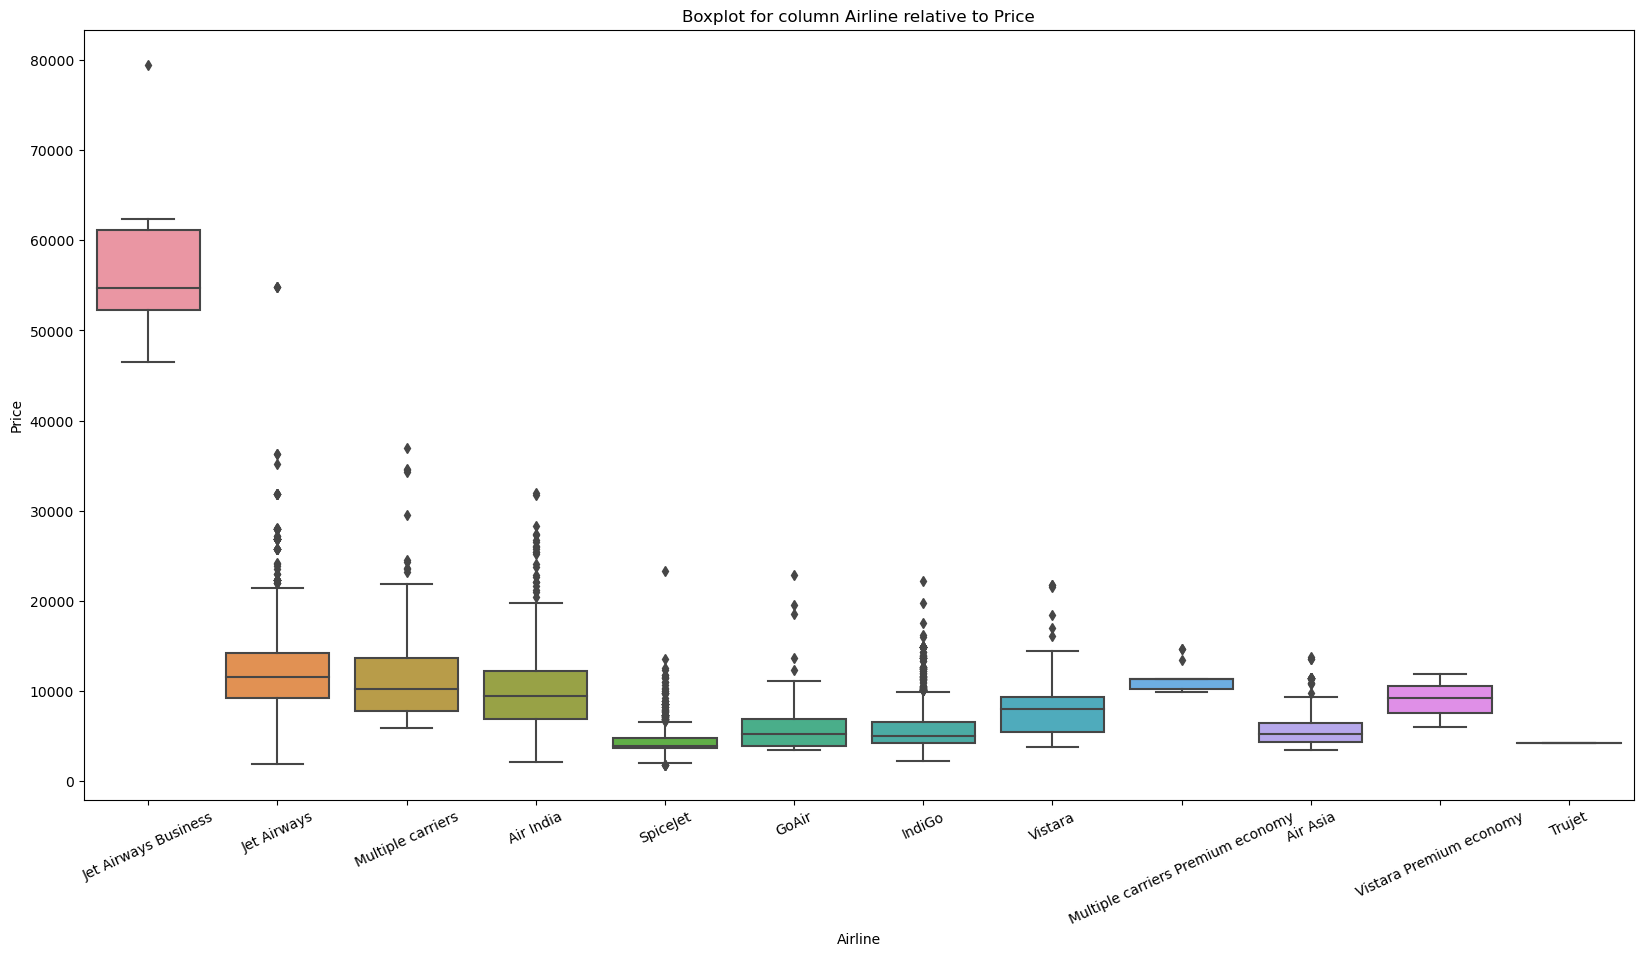

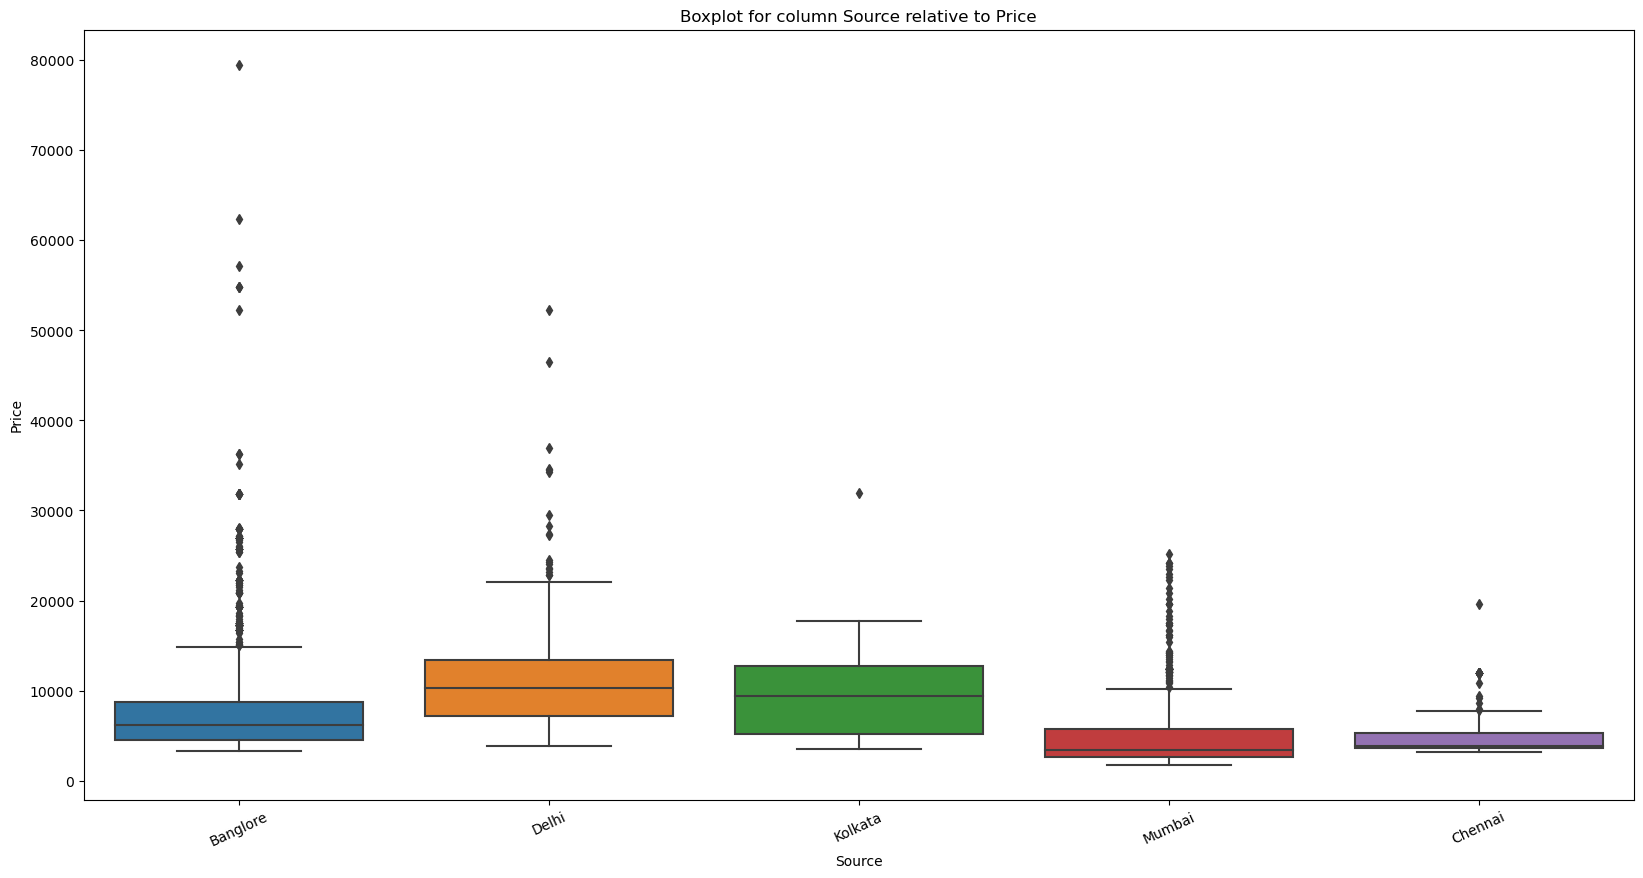

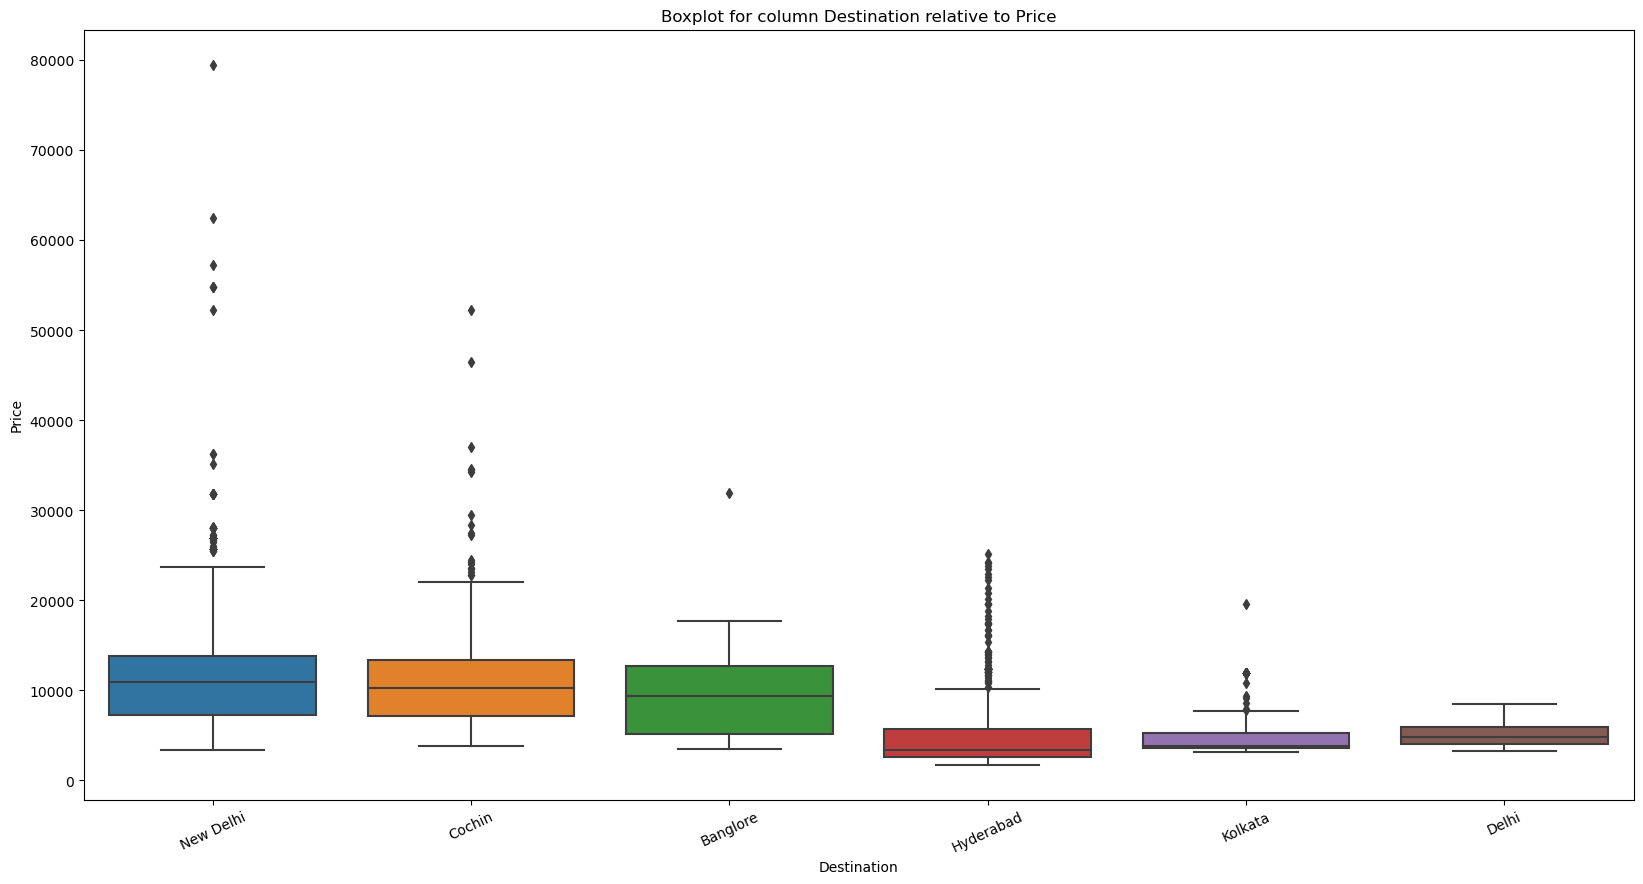

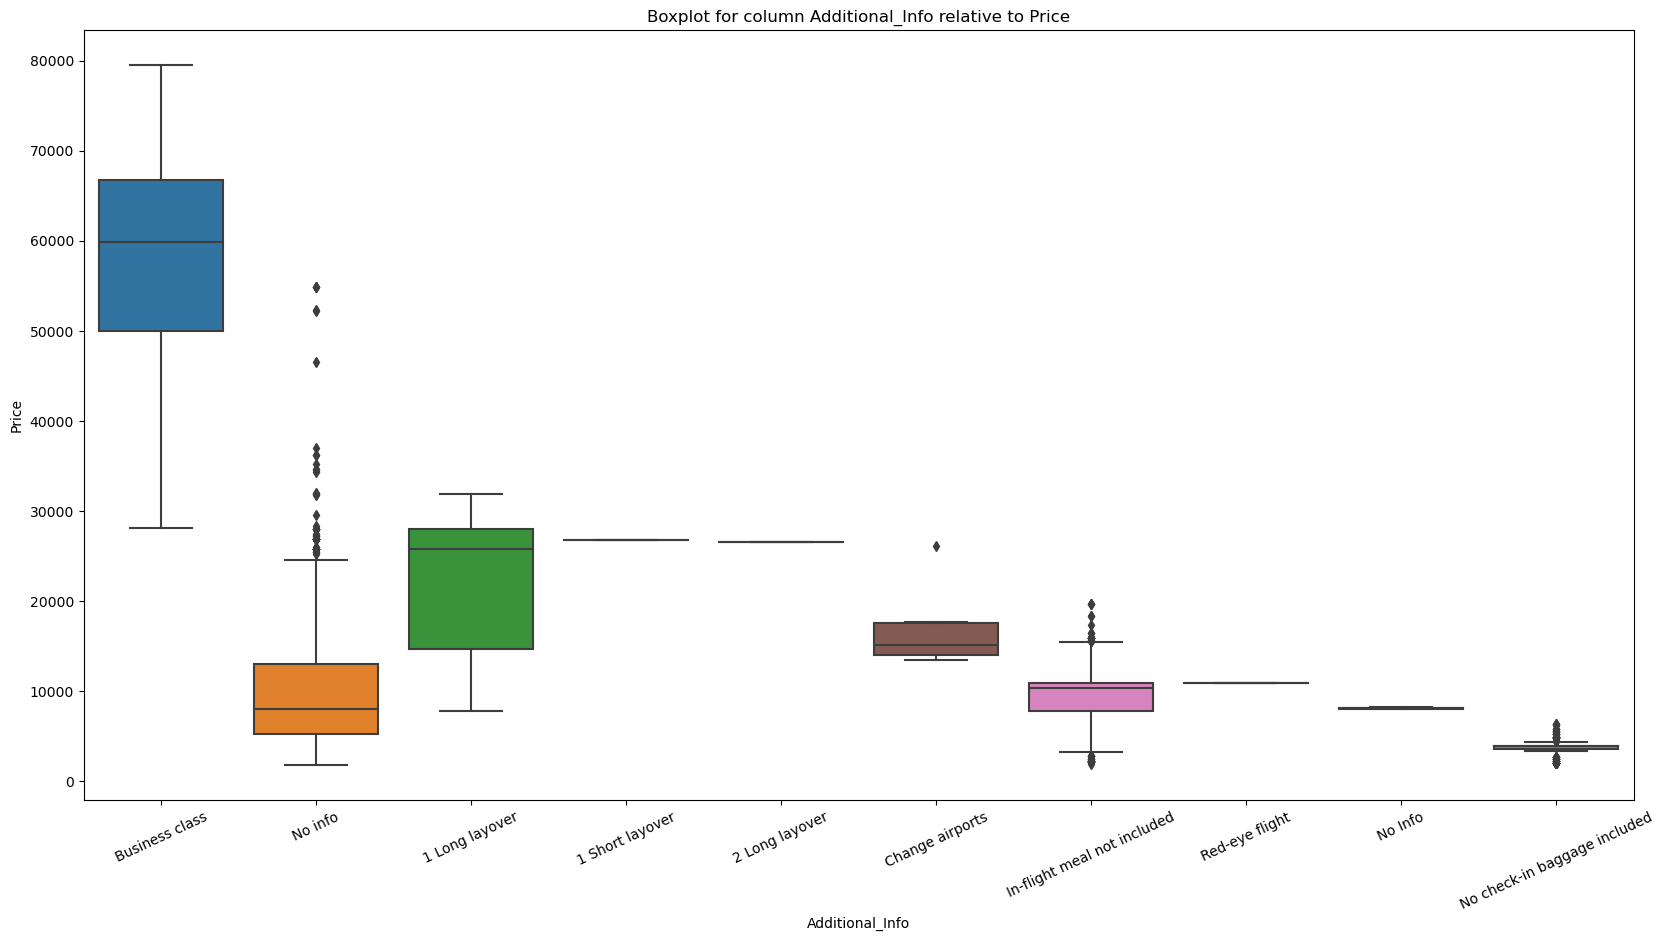

In [7]:
for column in ['Airline', 'Source', 'Destination', 'Additional_Info']:
    plt.figure(figsize = (20,10))
    ax = sns.boxplot(x = column, y = 'Price', data = df_processed_dates.sort_values('Price', ascending = False))
    ax.set_title(f"Boxplot for column {column} relative to Price")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 25)
    plt.savefig(f"vis\\boxplot_{column}.png")
    plt.show()


<p>We can see from our boxplots that source and destination don't seem to impact the ticket value as much as airline and additional info. Airline seems to definitely impact the price of the ticket, and because of the fact that the records for airlines are better distributed than the column 'Additional_Info', we will focus on the the airline column</p>


In [8]:
df_processed_dates.groupby('Airline').describe()['Price'].sort_values('mean', ascending = False)

count          mean           std  \
Airline                                                                 
Jet Airways Business                  6.0  58358.666667  11667.596748   
Jet Airways                        3849.0  11643.923357   4258.940578   
Multiple carriers Premium economy    13.0  11418.846154   1717.153936   
Multiple carriers                  1196.0  10902.678094   3721.234997   
Air India                          1752.0   9611.210616   3900.952942   
Vistara Premium economy               3.0   8962.333333   2915.405518   
Vistara                             479.0   7796.348643   2914.298578   
GoAir                               194.0   5861.056701   2703.585767   
IndiGo                             2053.0   5673.682903   2264.142168   
Air Asia                            319.0   5590.260188   2027.362290   
SpiceJet                            818.0   4338.284841   1849.922514   
Trujet                                1.0   4140.000000           NaN   

                                       min      25%      50%       75%  \
Airline                                                                  
Jet Airways Business               46490.0  52243.0  54747.0  61122.50   
Jet Airways                         1840.0   9134.0  11467.0  14151.00   
Multiple carriers Premium economy   9845.0  10161.0  11269.0  11269.00   
Multiple carriers                   5797.0   7723.0  10197.0  13587.00   
Air India                           2050.0   6896.0   9443.0  12219.00   
Vistara Premium economy             5969.0   7547.0   9125.0  10459.00   
Vistara                             3687.0   5403.0   7980.0   9345.00   
GoAir                               3398.0   3898.0   5135.0   6811.25   
IndiGo                              2227.0   4226.0   5000.0   6494.00   
Air Asia                            3383.0   4282.0   5162.0   6451.00   
SpiceJet                            1759.0   3574.5   3873.0   4760.00   
Trujet                              4140.0   4140.0   4140.0   4140.00   

                                       max  
Airline                                     
Jet Airways Business               79512.0  
Jet Airways                        54826.0  
Multiple carriers Premium economy  14629.0  
Multiple carriers                  36983.0  
Air India                          31945.0  
Vistara Premium economy            11793.0  
Vistara                            21730.0  
GoAir                              22794.0  
IndiGo                             22153.0  
Air Asia                           13774.0  
SpiceJet                           23267.0  
Trujet                              4140.0

<h3>Apply One-Hot Encoding to Airline Name</h3>

In [9]:
#conda install -c conda-forge category_encoders
import category_encoders as ce

onehot_encoder=ce.OneHotEncoder(cols=['Airline'], handle_unknown='return_nan', return_df=True,  use_cat_names=True)
df_encoded_airlines = onehot_encoder.fit_transform(df_processed_dates)
df_encoded_airlines

Airline_IndiGo  Airline_Air India  Airline_Jet Airways  \
0                 1.0                0.0                  0.0   
1                 0.0                1.0                  0.0   
2                 0.0                0.0                  1.0   
3                 1.0                0.0                  0.0   
4                 1.0                0.0                  0.0   
...               ...                ...                  ...   
10678             0.0                0.0                  0.0   
10679             0.0                1.0                  0.0   
10680             0.0                0.0                  1.0   
10681             0.0                0.0                  0.0   
10682             0.0                1.0                  0.0   

       Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  \
0                   0.0                        0.0            0.0   
1                   0.0                        0.0            0.0   
2                   0.0                        0.0            0.0   
3                   0.0                        0.0            0.0   
4                   0.0                        0.0            0.0   
...                 ...                        ...            ...   
10678               0.0                        0.0            0.0   
10679               0.0                        0.0            0.0   
10680               0.0                        0.0            0.0   
10681               0.0                        0.0            0.0   
10682               0.0                        0.0            0.0   

       Airline_Vistara  Airline_Air Asia  Airline_Vistara Premium economy  \
0                  0.0               0.0                              0.0   
1                  0.0               0.0                              0.0   
2                  0.0               0.0                              0.0   
3                  0.0               0.0                              0.0   
4                  0.0               0.0                              0.0   
...                ...               ...                              ...   
10678              0.0               1.0                              0.0   
10679              0.0               0.0                              0.0   
10680              0.0               0.0                              0.0   
10681              1.0               0.0                              0.0   
10682              0.0               0.0                              0.0   

       Airline_Jet Airways Business  ...  Total_Stops  Additional_Info  Price  \
0                               0.0  ...     non-stop          No info   3897   
1                               0.0  ...      2 stops          No info   7662   
2                               0.0  ...      2 stops          No info  13882   
3                               0.0  ...       1 stop          No info   6218   
4                               0.0  ...       1 stop          No info  13302   
...                             ...  ...          ...              ...    ...   
10678                           0.0  ...     non-stop          No info   4107   
10679                           0.0  ...     non-stop          No info   4145   
10680                           0.0  ...     non-stop          No info   7229   
10681                           0.0  ...     non-stop          No info  12648   
10682                           0.0  ...      2 stops          No info  11753   

             dep_datetime duration_hours duration_minutes timedelta_duration  \
0     2019-03-24 22:20:00              2               50    0 days 02:50:00   
1     2019-05-01 05:50:00              7               25    0 days 07:25:00   
2     2019-06-09 09:25:00             19                0    0 days 19:00:00   
3     2019-05-12 18:05:00              5               25    0 days 05:25:00   
4     2019-03-01 16:50:00              4               45    0 days 04:45:00   
...                

In [10]:
# We notice that there are two types of airlines for two airline companies
# Those are: 
#     Airline_Vistara with Airline_Vistara_Premium
#     Airline_JetAirways with Airline_JetAirways_Business

<h3>Apply One-Hot Encoding for Source and Destination columns</h3>

In [11]:
onehot_encoder=ce.OneHotEncoder(cols=['Source', 'Destination'], handle_unknown='return_nan', 
                                return_df=True, use_cat_names=True)
df_encoded_srcdest = onehot_encoder.fit_transform(df_encoded_airlines)
df_encoded_srcdest.columns

Index(['Airline_IndiGo', 'Airline_Air India', 'Airline_Jet Airways',
       'Airline_SpiceJet', 'Airline_Multiple carriers', 'Airline_GoAir',
       'Airline_Vistara', 'Airline_Air Asia',
       'Airline_Vistara Premium economy', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers Premium economy', 'Airline_Trujet',
       'Date_of_Journey', 'Source_Banglore', 'Source_Kolkata', 'Source_Delhi',
       'Source_Chennai', 'Source_Mumbai', 'Destination_New Delhi',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Kolkata',
       'Destination_Delhi', 'Destination_Hyderabad', 'Route', 'Dep_Time',
       'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info', 'Price',
       'dep_datetime', 'duration_hours', 'duration_minutes',
       'timedelta_duration', 'arr_datetime', 'Departure_City_Population',
       'Arrival_City_Population'],
      dtype='object')

<h3>Preprocess Date of Journey</h3>

In [12]:
#testing splitting the date
#df['Date_of_Journey'].iloc[0].dt.year
#df.iloc[0, ['Date_of_Journey']].dt.year

df_before_preprocess_dates = df_encoded_srcdest
print(df_before_preprocess_dates)
df_before_preprocess_dates['dep_year'] = df_before_preprocess_dates['dep_datetime'].dt.year
df_before_preprocess_dates['dep_month'] = df_before_preprocess_dates['dep_datetime'].dt.month
df_before_preprocess_dates['dep_day'] = df_before_preprocess_dates['dep_datetime'].dt.day
df_before_preprocess_dates['dep_hour'] = df_before_preprocess_dates['dep_datetime'].dt.hour
df_before_preprocess_dates['dep_minute'] = df_before_preprocess_dates['dep_datetime'].dt.minute

df_before_preprocess_dates['arr_year'] = df_before_preprocess_dates['arr_datetime'].dt.year
df_before_preprocess_dates['arr_month'] = df_before_preprocess_dates['arr_datetime'].dt.month
df_before_preprocess_dates['arr_day'] = df_before_preprocess_dates['arr_datetime'].dt.day
df_before_preprocess_dates['arr_hour'] = df_before_preprocess_dates['arr_datetime'].dt.hour
df_before_preprocess_dates['arr_minute'] = df_before_preprocess_dates['arr_datetime'].dt.minute



       Airline_IndiGo  Airline_Air India  Airline_Jet Airways  \
0                 1.0                0.0                  0.0   
1                 0.0                1.0                  0.0   
2                 0.0                0.0                  1.0   
3                 1.0                0.0                  0.0   
4                 1.0                0.0                  0.0   
...               ...                ...                  ...   
10678             0.0                0.0                  0.0   
10679             0.0                1.0                  0.0   
10680             0.0                0.0                  1.0   
10681             0.0                0.0                  0.0   
10682             0.0                1.0                  0.0   

       Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  \
0                   0.0                        0.0            0.0   
1                   0.0                        0.0            0.0   
2           

In [13]:
#display the dataframne
df_processed_dates = df_before_preprocess_dates
df_processed_dates

Airline_IndiGo  Airline_Air India  Airline_Jet Airways  \
0                 1.0                0.0                  0.0   
1                 0.0                1.0                  0.0   
2                 0.0                0.0                  1.0   
3                 1.0                0.0                  0.0   
4                 1.0                0.0                  0.0   
...               ...                ...                  ...   
10678             0.0                0.0                  0.0   
10679             0.0                1.0                  0.0   
10680             0.0                0.0                  1.0   
10681             0.0                0.0                  0.0   
10682             0.0                1.0                  0.0   

       Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  \
0                   0.0                        0.0            0.0   
1                   0.0                        0.0            0.0   
2                   0.0                        0.0            0.0   
3                   0.0                        0.0            0.0   
4                   0.0                        0.0            0.0   
...                 ...                        ...            ...   
10678               0.0                        0.0            0.0   
10679               0.0                        0.0            0.0   
10680               0.0                        0.0            0.0   
10681               0.0                        0.0            0.0   
10682               0.0                        0.0            0.0   

       Airline_Vistara  Airline_Air Asia  Airline_Vistara Premium economy  \
0                  0.0               0.0                              0.0   
1                  0.0               0.0                              0.0   
2                  0.0               0.0                              0.0   
3                  0.0               0.0                              0.0   
4                  0.0               0.0                              0.0   
...                ...               ...                              ...   
10678              0.0               1.0                              0.0   
10679              0.0               0.0                              0.0   
10680              0.0               0.0                              0.0   
10681              1.0               0.0                              0.0   
10682              0.0               0.0                              0.0   

       Airline_Jet Airways Business  ...  dep_year  dep_month dep_day  \
0                               0.0  ...      2019          3      24   
1                               0.0  ...      2019          5       1   
2                               0.0  ...      2019          6       9   
3                               0.0  ...      2019          5      12   
4                               0.0  ...      2019          3       1   
...                             ...  ...       ...        ...     ...   
10678                           0.0  ...      2019          4       9   
10679                           0.0  ...      2019          4      27   
10680                           0.0  ...      2019          4      27   
10681                           0.0  ...      2019          3       1   
10682                           0.0  ...      2019          5       9   

       dep_hour  dep_minute  arr_year  arr_month  arr_day  arr_hour  \
0            22          20      2019          3       25         1   
1             5          50      2019          5        1        13   
2             9          25      2019          6       10         4   
3            18           5      2019          5       12        23   
4            16          50      2019          3        1        21   
...         ...         ...       ...        ...      ...       ...   
10678        19          55      2019          4        9        22   
10679        20          45

In [14]:
#df_processed_dates.columns
df_processed_dates.shape
print("type",type(df_processed_dates.iloc[0][:]))
df_processed_dates.info()

type <class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 48 columns):
 #   Column                                     Non-Null Count  Dtype          
---  ------                                     --------------  -----          
 0   Airline_IndiGo                             10683 non-null  float64        
 1   Airline_Air India                          10683 non-null  float64        
 2   Airline_Jet Airways                        10683 non-null  float64        
 3   Airline_SpiceJet                           10683 non-null  float64        
 4   Airline_Multiple carriers                  10683 non-null  float64        
 5   Airline_GoAir                              10683 non-null  float64        
 6   Airline_Vistara                            10683 non-null  float64        
 7   Airline_Air Asia                           10683 non-null  float64        
 8   Airline_Vistara Premium economy            10

In [15]:
#We will drop columns dep_datetime and arr_datetime as we will represent them with sin and cos
#we will also cast columns duration_hours and duration_minutes to 
df_processed_dates = df_processed_dates.astype({'duration_hours':'int64', 'duration_minutes':'int64'})
#df_processed_dates = df_processed_dates.drop(['dep_datetime', 'arr_datetime'], axis=1)
df_processed_dates

Airline_IndiGo  Airline_Air India  Airline_Jet Airways  \
0                 1.0                0.0                  0.0   
1                 0.0                1.0                  0.0   
2                 0.0                0.0                  1.0   
3                 1.0                0.0                  0.0   
4                 1.0                0.0                  0.0   
...               ...                ...                  ...   
10678             0.0                0.0                  0.0   
10679             0.0                1.0                  0.0   
10680             0.0                0.0                  1.0   
10681             0.0                0.0                  0.0   
10682             0.0                1.0                  0.0   

       Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  \
0                   0.0                        0.0            0.0   
1                   0.0                        0.0            0.0   
2                   0.0                        0.0            0.0   
3                   0.0                        0.0            0.0   
4                   0.0                        0.0            0.0   
...                 ...                        ...            ...   
10678               0.0                        0.0            0.0   
10679               0.0                        0.0            0.0   
10680               0.0                        0.0            0.0   
10681               0.0                        0.0            0.0   
10682               0.0                        0.0            0.0   

       Airline_Vistara  Airline_Air Asia  Airline_Vistara Premium economy  \
0                  0.0               0.0                              0.0   
1                  0.0               0.0                              0.0   
2                  0.0               0.0                              0.0   
3                  0.0               0.0                              0.0   
4                  0.0               0.0                              0.0   
...                ...               ...                              ...   
10678              0.0               1.0                              0.0   
10679              0.0               0.0                              0.0   
10680              0.0               0.0                              0.0   
10681              1.0               0.0                              0.0   
10682              0.0               0.0                              0.0   

       Airline_Jet Airways Business  ...  dep_year  dep_month dep_day  \
0                               0.0  ...      2019          3      24   
1                               0.0  ...      2019          5       1   
2                               0.0  ...      2019          6       9   
3                               0.0  ...      2019          5      12   
4                               0.0  ...      2019          3       1   
...                             ...  ...       ...        ...     ...   
10678                           0.0  ...      2019          4       9   
10679                           0.0  ...      2019          4      27   
10680                           0.0  ...      2019          4      27   
10681                           0.0  ...      2019          3       1   
10682                           0.0  ...      2019          5       9   

       dep_hour  dep_minute  arr_year  arr_month  arr_day  arr_hour  \
0            22          20      2019          3       25         1   
1             5          50      2019          5        1        13   
2             9          25      2019          6       10         4   
3            18           5      2019          5       12        23   
4            16          50      2019          3        1        21   
...         ...         ...       ...        ...      ...       ...   
10678        19          55      2019          4        9        22   
10679        20          45

In [16]:
df_processed_dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 48 columns):
 #   Column                                     Non-Null Count  Dtype          
---  ------                                     --------------  -----          
 0   Airline_IndiGo                             10683 non-null  float64        
 1   Airline_Air India                          10683 non-null  float64        
 2   Airline_Jet Airways                        10683 non-null  float64        
 3   Airline_SpiceJet                           10683 non-null  float64        
 4   Airline_Multiple carriers                  10683 non-null  float64        
 5   Airline_GoAir                              10683 non-null  float64        
 6   Airline_Vistara                            10683 non-null  float64        
 7   Airline_Air Asia                           10683 non-null  float64        
 8   Airline_Vistara Premium economy            10683 non-null  float64        
 9   Airlin

<h3>Preprocessing the Total_Stops column</h3>

In [17]:
#We want to create a column stops that has:
# 0 - if non-stop
# 1 - if 1 stop
# 2 - if 2 stops
# 3 - if 3 stops
# 4 - if 4 stops
# and so on...


#We will print the distinct values in this column to find all available options
df_processed_dates['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', nan, '4 stops'],
      dtype=object)

We noticed that there are nan in this column. By investigating the excel file (sorting column Total_Stops), we can see that there is an entry with a lot of missing information with regards to route and total stops, and a very high duration, which makes it impossible to predict which stops the flight made. We decided to remove this record. This is the <b>only</b> empty record that we found in our train dataset

In [18]:
df_processed_dates.shape

(10683, 48)

In [19]:
df_removed_nulls = df_processed_dates.dropna(subset=['Total_Stops'])

In [20]:
df_removed_nulls.shape

(10682, 48)

We are correct in noticing that only one record will be removed, which should not impact our results later on.

In [21]:
df_removed_nulls['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [22]:
import re

def match_stops(x):
    if x == 'non-stop':
        return 0
    else:
        #split the string in tokens based on space
        #1st token is the number
        #2nd token is stop  | stops
        #s = x.split(' ')
        
        parts = re.findall('\d+', x)
        
        #print(parts[0])
        #parse the string to an integer
        return int(parts[0])
    
df_removed_nulls['num_stops'] = df_removed_nulls['Total_Stops'].apply(lambda x: match_stops(x))

df_removed_nulls

df_processed_stops = df_removed_nulls

C:\Users\panay\AppData\Local\Temp\ipykernel_13868\1257821010.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed_nulls['num_stops'] = df_removed_nulls['Total_Stops'].apply(lambda x: match_stops(x))


<h3>Preprocessing the additional info column</h3>

In [23]:
df_processed_stops['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

We can see that there are two distinct values that represent the same thing
'No info' and 'No Info'. We will combine these values to represent the same thing, and then apply one-hot encoding.

In [24]:
num1 = (df_processed_stops['Additional_Info'] == 'No Info').sum()
num2 = (df_processed_stops['Additional_Info'] == 'No info').sum()
print(num1,num2)

df_processed_stops

3 8344


Airline_IndiGo  Airline_Air India  Airline_Jet Airways  \
0                 1.0                0.0                  0.0   
1                 0.0                1.0                  0.0   
2                 0.0                0.0                  1.0   
3                 1.0                0.0                  0.0   
4                 1.0                0.0                  0.0   
...               ...                ...                  ...   
10678             0.0                0.0                  0.0   
10679             0.0                1.0                  0.0   
10680             0.0                0.0                  1.0   
10681             0.0                0.0                  0.0   
10682             0.0                1.0                  0.0   

       Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  \
0                   0.0                        0.0            0.0   
1                   0.0                        0.0            0.0   
2                   0.0                        0.0            0.0   
3                   0.0                        0.0            0.0   
4                   0.0                        0.0            0.0   
...                 ...                        ...            ...   
10678               0.0                        0.0            0.0   
10679               0.0                        0.0            0.0   
10680               0.0                        0.0            0.0   
10681               0.0                        0.0            0.0   
10682               0.0                        0.0            0.0   

       Airline_Vistara  Airline_Air Asia  Airline_Vistara Premium economy  \
0                  0.0               0.0                              0.0   
1                  0.0               0.0                              0.0   
2                  0.0               0.0                              0.0   
3                  0.0               0.0                              0.0   
4                  0.0               0.0                              0.0   
...                ...               ...                              ...   
10678              0.0               1.0                              0.0   
10679              0.0               0.0                              0.0   
10680              0.0               0.0                              0.0   
10681              1.0               0.0                              0.0   
10682              0.0               0.0                              0.0   

       Airline_Jet Airways Business  ...  dep_month  dep_day dep_hour  \
0                               0.0  ...          3       24       22   
1                               0.0  ...          5        1        5   
2                               0.0  ...          6        9        9   
3                               0.0  ...          5       12       18   
4                               0.0  ...          3        1       16   
...                             ...  ...        ...      ...      ...   
10678                           0.0  ...          4        9       19   
10679                           0.0  ...          4       27       20   
10680                           0.0  ...          4       27        8   
10681                           0.0  ...          3        1       11   
10682                           0.0  ...          5        9       10   

       dep_minute  arr_year  arr_month  arr_day  arr_hour  arr_minute  \
0              20      2019          3       25         1          10   
1              50      2019          5        1        13          15   
2              25      2019          6       10         4          25   
3               5      2019          5       12        23          30   
4              50      2019          3        1        21          35   
...           ...       ...        ...      ...       ...         ...   
10678          55      2019          4        9        22          25   
10679      

In [25]:
df_processed_stops['Additional_Info'] = df_processed_stops['Additional_Info'].replace({"No info":"No Info"})

df_processed_stops

C:\Users\panay\AppData\Local\Temp\ipykernel_13868\142972204.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed_stops['Additional_Info'] = df_processed_stops['Additional_Info'].replace({"No info":"No Info"})


Airline_IndiGo  Airline_Air India  Airline_Jet Airways  \
0                 1.0                0.0                  0.0   
1                 0.0                1.0                  0.0   
2                 0.0                0.0                  1.0   
3                 1.0                0.0                  0.0   
4                 1.0                0.0                  0.0   
...               ...                ...                  ...   
10678             0.0                0.0                  0.0   
10679             0.0                1.0                  0.0   
10680             0.0                0.0                  1.0   
10681             0.0                0.0                  0.0   
10682             0.0                1.0                  0.0   

       Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  \
0                   0.0                        0.0            0.0   
1                   0.0                        0.0            0.0   
2                   0.0                        0.0            0.0   
3                   0.0                        0.0            0.0   
4                   0.0                        0.0            0.0   
...                 ...                        ...            ...   
10678               0.0                        0.0            0.0   
10679               0.0                        0.0            0.0   
10680               0.0                        0.0            0.0   
10681               0.0                        0.0            0.0   
10682               0.0                        0.0            0.0   

       Airline_Vistara  Airline_Air Asia  Airline_Vistara Premium economy  \
0                  0.0               0.0                              0.0   
1                  0.0               0.0                              0.0   
2                  0.0               0.0                              0.0   
3                  0.0               0.0                              0.0   
4                  0.0               0.0                              0.0   
...                ...               ...                              ...   
10678              0.0               1.0                              0.0   
10679              0.0               0.0                              0.0   
10680              0.0               0.0                              0.0   
10681              1.0               0.0                              0.0   
10682              0.0               0.0                              0.0   

       Airline_Jet Airways Business  ...  dep_month  dep_day dep_hour  \
0                               0.0  ...          3       24       22   
1                               0.0  ...          5        1        5   
2                               0.0  ...          6        9        9   
3                               0.0  ...          5       12       18   
4                               0.0  ...          3        1       16   
...                             ...  ...        ...      ...      ...   
10678                           0.0  ...          4        9       19   
10679                           0.0  ...          4       27       20   
10680                           0.0  ...          4       27        8   
10681                           0.0  ...          3        1       11   
10682                           0.0  ...          5        9       10   

       dep_minute  arr_year  arr_month  arr_day  arr_hour  arr_minute  \
0              20      2019          3       25         1          10   
1              50      2019          5        1        13          15   
2              25      2019          6       10         4          25   
3               5      2019          5       12        23          30   
4              50      2019          3        1        21          35   
...           ...       ...        ...      ...       ...         ...   
10678          55      2019          4        9        22          25   
10679      

In [26]:
num3 = (df_processed_stops['Additional_Info'] == 'No Info').sum()
print(num3)


8347


Through printing the count of records with 'No info' and 'No Info' in the dataframe, we have verified that the values have changed correctly

In [27]:
df_processed_stops['Additional_Info'].unique()

array(['No Info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

The 'No info' values have been replaced with 'No Info'

In [28]:
onehot_encoder = ce.OneHotEncoder(cols=['Additional_Info'], handle_unknown='return_nan', return_df=True, use_cat_names=True)
df_processed_info = onehot_encoder.fit_transform(df_processed_stops)
df_processed_info


Airline_IndiGo  Airline_Air India  Airline_Jet Airways  \
0                 1.0                0.0                  0.0   
1                 0.0                1.0                  0.0   
2                 0.0                0.0                  1.0   
3                 1.0                0.0                  0.0   
4                 1.0                0.0                  0.0   
...               ...                ...                  ...   
10678             0.0                0.0                  0.0   
10679             0.0                1.0                  0.0   
10680             0.0                0.0                  1.0   
10681             0.0                0.0                  0.0   
10682             0.0                1.0                  0.0   

       Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  \
0                   0.0                        0.0            0.0   
1                   0.0                        0.0            0.0   
2                   0.0                        0.0            0.0   
3                   0.0                        0.0            0.0   
4                   0.0                        0.0            0.0   
...                 ...                        ...            ...   
10678               0.0                        0.0            0.0   
10679               0.0                        0.0            0.0   
10680               0.0                        0.0            0.0   
10681               0.0                        0.0            0.0   
10682               0.0                        0.0            0.0   

       Airline_Vistara  Airline_Air Asia  Airline_Vistara Premium economy  \
0                  0.0               0.0                              0.0   
1                  0.0               0.0                              0.0   
2                  0.0               0.0                              0.0   
3                  0.0               0.0                              0.0   
4                  0.0               0.0                              0.0   
...                ...               ...                              ...   
10678              0.0               1.0                              0.0   
10679              0.0               0.0                              0.0   
10680              0.0               0.0                              0.0   
10681              1.0               0.0                              0.0   
10682              0.0               0.0                              0.0   

       Airline_Jet Airways Business  ...  dep_month  dep_day dep_hour  \
0                               0.0  ...          3       24       22   
1                               0.0  ...          5        1        5   
2                               0.0  ...          6        9        9   
3                               0.0  ...          5       12       18   
4                               0.0  ...          3        1       16   
...                             ...  ...        ...      ...      ...   
10678                           0.0  ...          4        9       19   
10679                           0.0  ...          4       27       20   
10680                           0.0  ...          4       27        8   
10681                           0.0  ...          3        1       11   
10682                           0.0  ...          5        9       10   

       dep_minute  arr_year  arr_month  arr_day  arr_hour  arr_minute  \
0              20      2019          3       25         1          10   
1              50      2019          5        1        13          15   
2              25      2019          6       10         4          25   
3               5      2019          5       12        23          30   
4              50      2019          3        1        21          35   
...           ...       ...        ...      ...       ...         ...   
10678          55      2019          4        9        22          25   
10679      

In [29]:
df_processed_info.columns

Index(['Airline_IndiGo', 'Airline_Air India', 'Airline_Jet Airways',
       'Airline_SpiceJet', 'Airline_Multiple carriers', 'Airline_GoAir',
       'Airline_Vistara', 'Airline_Air Asia',
       'Airline_Vistara Premium economy', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers Premium economy', 'Airline_Trujet',
       'Date_of_Journey', 'Source_Banglore', 'Source_Kolkata', 'Source_Delhi',
       'Source_Chennai', 'Source_Mumbai', 'Destination_New Delhi',
       'Destination_Banglore', 'Destination_Cochin', 'Destination_Kolkata',
       'Destination_Delhi', 'Destination_Hyderabad', 'Route', 'Dep_Time',
       'Arrival_Time', 'Duration', 'Total_Stops', 'Additional_Info_No Info',
       'Additional_Info_In-flight meal not included',
       'Additional_Info_No check-in baggage included',
       'Additional_Info_1 Short layover', 'Additional_Info_1 Long layover',
       'Additional_Info_Change airports', 'Additional_Info_Business class',
       'Additional_Info_Red-eye fl

In [30]:
df_processed_info.iloc[:, 29:40]

Additional_Info_No Info  Additional_Info_In-flight meal not included  \
0                          1.0                                          0.0   
1                          1.0                                          0.0   
2                          1.0                                          0.0   
3                          1.0                                          0.0   
4                          1.0                                          0.0   
...                        ...                                          ...   
10678                      1.0                                          0.0   
10679                      1.0                                          0.0   
10680                      1.0                                          0.0   
10681                      1.0                                          0.0   
10682                      1.0                                          0.0   

       Additional_Info_No check-in baggage included  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
...                                             ...   
10678                                           0.0   
10679                                           0.0   
10680                                           0.0   
10681                                           0.0   
10682                                           0.0   

       Additional_Info_1 Short layover  Additional_Info_1 Long layover  \
0                                  0.0                             0.0   
1                                  0.0                             0.0   
2                                  0.0                             0.0   
3                                  0.0                             0.0   
4                                  0.0                             0.0   
...                                ...                             ...   
10678                              0.0                             0.0   
10679                              0.0                             0.0   
10680                              0.0                             0.0   
10681                              0.0                             0.0   
10682                              0.0                             0.0   

       Additional_Info_Change airports  Additional_Info_Business class  \
0                                  0.0                             0.0   
1                                  0.0                             0.0   
2                                  0.0                             0.0   
3                                  0.0                             0.0   
4                                  0.0                             0.0   
...                                ...                             ...   
10678                              0.0                             0.0   
10679                              0.0                             0.0   
10680                              0.0                             0.0   
10681                              0.0                             0.0   
10682                              0.0                             0.0   

       Additional_Info_Red-eye flight  Additional_Info_2 Long layover  Price  \
0                                 0.0                             0.0   3897   
1                                 0.0                             0.0   7662   
2                                 0.0                             0.0  13882   
3                                 0.0                             0.0   6218   
4                                 0.0                             0.0  13302   
...                               ...                             ...    ...   
10678                             0.0                      

In [31]:
#df_processed_stops['Additional_Info'] = df_processed_stops['Additional_Info'].replace({"No info":"No Info"})

df_processed_info['Additional_Info_2 Long layover'] = df_processed_info['Additional_Info_2 Long layover'] * 2.0

df_processed_info['Additional_Info_Layovers'] = df_processed_info['Additional_Info_2 Long layover'] + df_processed_info['Additional_Info_1 Long layover']

#RUN THIS ONLY ONCE ELSE THE COLUMNS WILL HAVE WRONG RESULTS

In [32]:
df_processed_info.loc[:,['Additional_Info_Layovers']]

df_processed_info['Additional_Info_Layovers'].unique()

array([0., 1., 2.])

In [33]:
df_processed_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 58 columns):
 #   Column                                        Non-Null Count  Dtype          
---  ------                                        --------------  -----          
 0   Airline_IndiGo                                10682 non-null  float64        
 1   Airline_Air India                             10682 non-null  float64        
 2   Airline_Jet Airways                           10682 non-null  float64        
 3   Airline_SpiceJet                              10682 non-null  float64        
 4   Airline_Multiple carriers                     10682 non-null  float64        
 5   Airline_GoAir                                 10682 non-null  float64        
 6   Airline_Vistara                               10682 non-null  float64        
 7   Airline_Air Asia                              10682 non-null  float64        
 8   Airline_Vistara Premium economy               10682 non-

In [34]:
#remove unnecessary columns
#df_processed_info.drop(['Additional_Info_2 Long layover', 'Additional_Info_1 Long layover', 'Total_Stops'])
df_cyclical = df_processed_info

<h3>Cyclical transformation on columns that represent date, time etc.</h3>
np.sin and np.cos

<b>NOTE: We will transform day and month to a day out of 365 to represent it cyclically better</b>



In [35]:
# df_cyclical['dep_month_sin'] = np.sin(2 * np.pi * df_cyclical['dep_month']/11.0)
# df_cyclical['dep_month_cos'] = np.cos(2 * np.pi * df_cyclical['dep_month']/11.0)

# df_cyclical['arr_month_sin'] = np.sin(2 * np.pi * df_cyclical['arr_month']/11.0)
# df_cyclical['arr_month_cos'] = np.cos(2 * np.pi * df_cyclical['arr_month']/11.0)


# df_cyclical['dep_day_sin'] = np.sin(2 * np.pi * df_cyclical['dep_day']/)
# df_cyclical['dep_day_cos'] = np.cos(2 * np.pi * df_cyclical['dep_day']/)

# df_cyclical['arr_day_sin'] = np.sin(2 * np.pi * df_cyclical['arr_day']/)
# df_cyclical['arr_day_cos'] = np.cos(2 * np.pi * df_cyclical['arr_day']/)

#encode hours
df_cyclical['dep_hour_sin'] = np.sin(2 * np.pi * df_cyclical['dep_hour']/23.0)
df_cyclical['dep_hour_cos'] = np.cos(2 * np.pi * df_cyclical['dep_hour']/23.0)

df_cyclical['arr_hour_sin'] = np.sin(2 * np.pi * df_cyclical['arr_hour']/23.0)
df_cyclical['arr_hour_cos'] = np.cos(2 * np.pi * df_cyclical['arr_hour']/23.0)

#encode minutes
df_cyclical['dep_minute_sin'] = np.sin(2 * np.pi * df_cyclical['dep_minute']/59.0)
df_cyclical['dep_minute_cos'] = np.cos(2 * np.pi * df_cyclical['dep_minute']/59.0)

df_cyclical['arr_minute_sin'] = np.sin(2 * np.pi * df_cyclical['arr_minute']/59.0)
df_cyclical['arr_minute_cos'] = np.cos(2 * np.pi * df_cyclical['arr_minute']/59.0)



In [36]:
def get_dep_day_of_year(row):
    return row['dep_datetime'].timetuple().tm_yday

def get_arr_day_of_year(row):
    return row['arr_datetime'].timetuple().tm_yday


#day of the year encoding
df_cyclical['dep_day_of_year'] = df_cyclical.apply(get_dep_day_of_year, axis=1)

df_cyclical['arr_day_of_year'] = df_cyclical.apply(get_arr_day_of_year, axis=1)

In [37]:
df_cyclical

Airline_IndiGo  Airline_Air India  Airline_Jet Airways  \
0                 1.0                0.0                  0.0   
1                 0.0                1.0                  0.0   
2                 0.0                0.0                  1.0   
3                 1.0                0.0                  0.0   
4                 1.0                0.0                  0.0   
...               ...                ...                  ...   
10678             0.0                0.0                  0.0   
10679             0.0                1.0                  0.0   
10680             0.0                0.0                  1.0   
10681             0.0                0.0                  0.0   
10682             0.0                1.0                  0.0   

       Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  \
0                   0.0                        0.0            0.0   
1                   0.0                        0.0            0.0   
2                   0.0                        0.0            0.0   
3                   0.0                        0.0            0.0   
4                   0.0                        0.0            0.0   
...                 ...                        ...            ...   
10678               0.0                        0.0            0.0   
10679               0.0                        0.0            0.0   
10680               0.0                        0.0            0.0   
10681               0.0                        0.0            0.0   
10682               0.0                        0.0            0.0   

       Airline_Vistara  Airline_Air Asia  Airline_Vistara Premium economy  \
0                  0.0               0.0                              0.0   
1                  0.0               0.0                              0.0   
2                  0.0               0.0                              0.0   
3                  0.0               0.0                              0.0   
4                  0.0               0.0                              0.0   
...                ...               ...                              ...   
10678              0.0               1.0                              0.0   
10679              0.0               0.0                              0.0   
10680              0.0               0.0                              0.0   
10681              1.0               0.0                              0.0   
10682              0.0               0.0                              0.0   

       Airline_Jet Airways Business  ...  dep_hour_sin  dep_hour_cos  \
0                               0.0  ...     -0.269797      0.962917   
1                               0.0  ...      0.979084      0.203456   
2                               0.0  ...      0.631088     -0.775711   
3                               0.0  ...     -0.979084      0.203456   
4                               0.0  ...     -0.942261     -0.334880   
...                             ...  ...           ...           ...   
10678                           0.0  ...     -0.887885      0.460065   
10679                           0.0  ...     -0.730836      0.682553   
10680                           0.0  ...      0.816970     -0.576680   
10681                           0.0  ...      0.136167     -0.990686   
10682                           0.0  ...      0.398401     -0.917211   

       arr_hour_sin  arr_hour_cos  dep_minute_sin  dep_minute_cos  \
0      2.697968e-01      0.962917        0.847734       -0.530421   
1     -3.984011e-01     -0.917211       -0.818303        0.574787   
2      8.878852e-01      0.460065        0.461093       -0.887352   
3     -2.449294e-16      1.000000        0.507666        0.861554   
4     -5.195840e-01      0.854419       -0.818303        0.574787   
...             ...           ...             ...             ...   
10678 -2.697968e-01      0.962917       -0.413212        0.910635   
10679 -2.449294e-16      1.000000       -0.996812      

In [38]:
# #create auxiliary columns that contain number of days in year and number of days in month in order to have more accurate cyclical representation

# import calendar

# def dep_find_days_in_year(row):
#     return 365 + calendar.isleap(row['dep_year'])

# def arr_find_days_in_year(row):
#     return 365 + calendar.isleap(row['arr_year'])

# def dep_find_days_in_month(row):
#     result = calendar.monthrange(row['dep_year'], row['dep_month'])
#     return result[1]

# def arr_find_days_in_month(row):
#     result = calendar.monthrange(row['arr_year'], row['arr_month'])
#     return result[1]


# df_cyclical['dep_day_of_year'] = df_cyclical.apply(get_dep_day_of_year, axis=1)

# df_cyclical['dep_days_in_year'] = df_cyclical.apply(dep_find_days_in_year, axis=1)
# df_cyclical['dep_days_in_month'] = df_cyclical.apply(dep_find_days_in_month, axis=1)
# df_cyclical['arr_days_in_year'] = df_cyclical.apply(arr_find_days_in_year, axis=1)
# df_cyclical['arr_days_in_month'] = df_cyclical.apply(arr_find_days_in_month, axis=1)



In [39]:
#create cyclical representation for day of the year
#WE ASSUME THAT ALL YEARS HAVE 366 DAYS - WE MIGHT IMPROVE ON THIS LATER
import calendar

def get_days_in_year(x):
    return 365 + calendar.isleap(x)

def get_days_in_month(x,y):
    result = calendar.monthrange(x,y)
    return result[1]
    

df_cyclical['dep_day_of_year_sin'] = np.sin(2 * np.pi * df_cyclical['dep_day'] / df_cyclical['dep_year'].apply(lambda x:get_days_in_year(x)))
df_cyclical['dep_day_of_year_cos'] = np.cos(2 * np.pi * df_cyclical['dep_day'] / df_cyclical['dep_year'].apply(lambda x:get_days_in_year(x)))

df_cyclical['arr_day_of_year_sin'] = np.sin(2 * np.pi * df_cyclical['arr_day'] / df_cyclical['arr_year'].apply(lambda x:get_days_in_year(x)))
df_cyclical['arr_day_of_year_cos'] = np.cos(2 * np.pi * df_cyclical['arr_day'] / df_cyclical['arr_year'].apply(lambda x:get_days_in_year(x)))


df_cyclical['dep_day_of_month_sin'] = np.sin(2 * np.pi * df_cyclical['dep_day'] / df_cyclical.apply(lambda x:get_days_in_month(x['dep_year'],x['dep_month']), axis=1))
df_cyclical['dep_day_of_month_cos'] = np.cos(2 * np.pi * df_cyclical['dep_day'] / df_cyclical.apply(lambda x:get_days_in_month(x['dep_year'],x['dep_month']), axis=1))

df_cyclical['arr_day_of_month_sin'] = np.sin(2 * np.pi * df_cyclical['arr_day'] / df_cyclical.apply(lambda x:get_days_in_month(x['arr_year'],x['arr_month']), axis=1))
df_cyclical['arr_day_of_month_cos'] = np.cos(2 * np.pi * df_cyclical['arr_day'] / df_cyclical.apply(lambda x:get_days_in_month(x['arr_year'],x['arr_month']), axis=1))



# df_cyclical['dep_day_of_year_sin'] = np.sin(2 * np.pi * df_cyclical['dep_day_of_year']/365.0)
# df_cyclical['dep_day_of_year_cos'] = np.cos(2 * np.pi * df_cyclical['dep_day_of_year']/365.0)

# df_cyclical['arr_day_of_year_sin'] = np.sin(2 * np.pi * df_cyclical['arr_day_of_year']/365.0)
# df_cyclical['arr_day_of_year_cos'] = np.cos(2 * np.pi * df_cyclical['arr_day_of_year']/365.0)

In [40]:
df_cyclical.iloc[12:20]

Airline_IndiGo  Airline_Air India  Airline_Jet Airways  Airline_SpiceJet  \
12             0.0                1.0                  0.0               0.0   
13             0.0                0.0                  1.0               0.0   
14             1.0                0.0                  0.0               0.0   
15             0.0                1.0                  0.0               0.0   
16             0.0                0.0                  0.0               1.0   
17             0.0                0.0                  1.0               0.0   
18             0.0                1.0                  0.0               0.0   
19             0.0                0.0                  1.0               0.0   

    Airline_Multiple carriers  Airline_GoAir  Airline_Vistara  \
12                        0.0            0.0              0.0   
13                        0.0            0.0              0.0   
14                        0.0            0.0              0.0   
15                        0.0            0.0              0.0   
16                        0.0            0.0              0.0   
17                        0.0            0.0              0.0   
18                        0.0            0.0              0.0   
19                        0.0            0.0              0.0   

    Airline_Air Asia  Airline_Vistara Premium economy  \
12               0.0                              0.0   
13               0.0                              0.0   
14               0.0                              0.0   
15               0.0                              0.0   
16               0.0                              0.0   
17               0.0                              0.0   
18               0.0                              0.0   
19               0.0                              0.0   

    Airline_Jet Airways Business  ...  dep_day_of_year  arr_day_of_year  \
12                           0.0  ...              175              175   
13                           0.0  ...              129              130   
14                           0.0  ...              114              114   
15                           0.0  ...               62               63   
16                           0.0  ...              105              105   
17                           0.0  ...              163              164   
18                           0.0  ...              163              164   
19                           0.0  ...              147              148   

   dep_day_of_year_sin  dep_day_of_year_cos  arr_day_of_year_sin  \
12            0.401488             0.915864             0.401488   
13            0.154309             0.988023             0.171293   
14            0.401488             0.915864             0.401488   
15            0.051620             0.998667             0.068802   
16            0.255353             0.966848             0.255353   
17            0.205104             0.978740             0.221922   
18            0.205104             0.978740             0.221922   
19            0.448229             0.893919             0.463550   

    arr_day_of_year_cos  dep_day_of_month_sin  dep_day_of_month_cos  \
12             0.915864         -9.510565e-01              0.309017   
13             0.985220          9.680771e-01             -0.250653   
14             0.915864         -9.510565e-01              0.309017   
15             0.997630          5.712682e-01              0.820763   
16             0.966848          5.665539e-16             -1.000000   
17             0.975065          5.877853e-01             -0.809017   
18             0.975065          5.877853e-01             -0.809017   
19             0.886071         -7.247928e-01              0.688967   

    arr_day_of_month_sin  arr_day_of_month_cos  
12         -9.510565e-01              0.309017  
13          8.978045e-01             -0.440394  
14         -9.510565e-01              0.309017  
15          7.247928e-01              0.688967  
16       

In [41]:
df_cyclical.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10682 entries, 0 to 10682
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype          
---  ------                                        --------------  -----          
 0   Airline_IndiGo                                10682 non-null  float64        
 1   Airline_Air India                             10682 non-null  float64        
 2   Airline_Jet Airways                           10682 non-null  float64        
 3   Airline_SpiceJet                              10682 non-null  float64        
 4   Airline_Multiple carriers                     10682 non-null  float64        
 5   Airline_GoAir                                 10682 non-null  float64        
 6   Airline_Vistara                               10682 non-null  float64        
 7   Airline_Air Asia                              10682 non-null  float64        
 8   Airline_Vistara Premium economy               10682 non-

In [42]:
df_cyclical.shape

(10682, 76)

In [43]:
def get_dep_day_of_week(row):
    return row['dep_datetime'].timetuple().tm_wday

def get_arr_day_of_week(row):
    return row['arr_datetime'].timetuple().tm_wday


#day of the year encoding
df_cyclical['dep_day_of_week'] = df_cyclical.apply(get_dep_day_of_week, axis=1)

df_cyclical['arr_day_of_week'] = df_cyclical.apply(get_arr_day_of_week, axis=1)

In [44]:
#create cyclical representation for day of the week
#0-Monday through 6-Sunday

df_cyclical['dep_day_of_week_sin'] = np.sin(2 * np.pi * df_cyclical['dep_day_of_week']/6.0)
df_cyclical['dep_day_of_week_cos'] = np.cos(2 * np.pi * df_cyclical['dep_day_of_week']/6.0)

df_cyclical['arr_day_of_week_sin'] = np.sin(2 * np.pi * df_cyclical['arr_day_of_week']/6.0)
df_cyclical['arr_day_of_week_cos'] = np.cos(2 * np.pi * df_cyclical['arr_day_of_week']/6.0)

<h3>Get the intermediate stops using split in route column</h3>

In [45]:
df_cyclical['Route']

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

In [46]:
df_cyclical['Route'] = df_cyclical['Route']

In [47]:
df_cyclical['Route'].unique()

array(['BLR → DEL', 'CCU → IXR → BBI → BLR', 'DEL → LKO → BOM → COK',
       'CCU → NAG → BLR', 'BLR → NAG → DEL', 'CCU → BLR',
       'BLR → BOM → DEL', 'DEL → BOM → COK', 'DEL → BLR → COK',
       'MAA → CCU', 'CCU → BOM → BLR', 'DEL → AMD → BOM → COK',
       'DEL → PNQ → COK', 'DEL → CCU → BOM → COK', 'BLR → COK → DEL',
       'DEL → IDR → BOM → COK', 'DEL → LKO → COK',
       'CCU → GAU → DEL → BLR', 'DEL → NAG → BOM → COK',
       'CCU → MAA → BLR', 'DEL → HYD → COK', 'CCU → HYD → BLR',
       'DEL → COK', 'CCU → DEL → BLR', 'BLR → BOM → AMD → DEL',
       'BOM → DEL → HYD', 'DEL → MAA → COK', 'BOM → HYD',
       'DEL → BHO → BOM → COK', 'DEL → JAI → BOM → COK',
       'DEL → ATQ → BOM → COK', 'DEL → JDH → BOM → COK',
       'CCU → BBI → BOM → BLR', 'BLR → MAA → DEL',
       'DEL → GOI → BOM → COK', 'DEL → BDQ → BOM → COK',
       'CCU → JAI → BOM → BLR', 'CCU → BBI → BLR', 'BLR → HYD → DEL',
       'DEL → TRV → COK', 'CCU → IXR → DEL → BLR',
       'DEL → IXU → BOM → COK', 'CCU 

In [48]:
import math

def distance_from_coordinates(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Earth's radius in km
    return c * r

In [49]:
# transform airport class to integer so the ML models understand them
def airport_class_string_to_int(air_class):
    if air_class == 'small':
        return 0
    elif air_class == 'medium':
        return 1
    else:
        return 2

def calculate_distance_from_route(df):
    
    #load the excel file containing geographic coordinates for each airport
    airport_information = pd.read_excel("Auxiliary_Data\indian_airports_locations.xlsx")
    airport_information.set_index('Airport', inplace=True)
    
    dict_airports = airport_information.to_dict()
    
#     print(dict_airports)
#     print(dict_airports['latitude']['HBX'])
#     print(dict_airports['longitude']['HBX'])
#     print(dict_airports['Airport_class']['HBX'])
    
    #this list will be added as a new column
    distances_list = list()
    departure_airport_class = list()
    arrival_airport_class = list()
    
    #Iterate through dataframe rows for all ['Route'] entries
    for index, route in df['Route'].iteritems():
        #The route string is in route
        #split route string into tokens
        tokens = route.split(" → ")
        
        #iterate until second to last index to calculate distance between current and next
        distance_covered = 0.0
        for index, airport in enumerate(tokens[:-1]):
            next_airport = tokens[index+1]
            
            lat1 = dict_airports['latitude'][airport]
            lon1 = dict_airports['longitude'][airport]
            
            lat2 = dict_airports['latitude'][next_airport]
            lon2 = dict_airports['longitude'][next_airport]
            
            #function that calculates distance in kilometers from 2 geographic coordinates
            km_distance = distance_from_coordinates(lat1, lon1, lat2, lon2)
            distance_covered = distance_covered + km_distance
            
            #WRONG
            #km_distance = math.acos(sin(lat1)*sin(lat2)+cos(lat1)*cos(lat2)*cos(lon2-lon1))*6371 #(6371 is Earth radius in km.)
        
        distances_list.append(distance_covered)
        
        #save the class of the airport
        departure_airport_class.append(airport_class_string_to_int(tokens[0]))
        arrival_airport_class.append(airport_class_string_to_int(tokens[-1]))
        
    #create new dataframe columns
    df['distance_covered_km'] = distances_list
    df['departure_airport_class'] = departure_airport_class
    df['arrival_airport_class'] = arrival_airport_class
    
    
    
    return df
            

In [50]:
df_cyclical = calculate_distance_from_route(df_cyclical)
print(df_cyclical[['distance_covered_km','Route','departure_airport_class', 'arrival_airport_class']])

       distance_covered_km                  Route  departure_airport_class  \
0              1710.049043              BLR → DEL                        2   
1              1839.048772  CCU → IXR → BBI → BLR                        2   
2              2670.870433  DEL → LKO → BOM → COK                        2   
3              1874.448660        CCU → NAG → BLR                        2   
4              1743.164232        BLR → NAG → DEL                        2   
...                    ...                    ...                      ...   
10678          1546.839920              CCU → BLR                        2   
10679          1546.839920              CCU → BLR                        2   
10680          1710.049043              BLR → DEL                        2   
10681          1710.049043              BLR → DEL                        2   
10682          2992.860423  DEL → GOI → BOM → COK                        2   

       arrival_airport_class  
0                          2  
1

C:\Users\panay\AppData\Local\Temp\ipykernel_13868\3701679047.py:29: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, route in df['Route'].iteritems():


In [51]:
def get_intermidiate_stops_dataframe(df_cyclical):
    stops = df_cyclical['Route'].unique()
    unique = set()
    for i in stops:
        tokens = i.split(" → ")
        for j in tokens[1:-1]:
            unique.add(j)

    data = {elem: [0]*len(df_cyclical) for elem in unique}
    df = pd.DataFrame(data)
    #print(df)
    
    stops = df_cyclical['Route']
    #stops is now a Series object
    #print(type(stops))
    
    for index, i in enumerate(stops):
        tokens = i.split(" → ")
        for j in tokens[1:-1]:
            df.iloc[index][j] = 1
    #print(df.loc[5050])
    
    print(df.shape)
    print(df_cyclical.shape)
    return df

In [52]:
df_stops = get_intermidiate_stops_dataframe(df_cyclical)
#print(df_cyclical)
#print(df_stops)

df_cyclical_copy = df_cyclical
df_cyclical_copy.reset_index(drop=True, inplace=True)
df_stops.reset_index(drop=True, inplace=True)

df_combined = pd.concat([df_cyclical_copy,df_stops],axis=1)
print(df_combined.shape)
print(df_combined)

(10682, 42)
(10682, 85)
(10682, 127)
       Airline_IndiGo  Airline_Air India  Airline_Jet Airways  \
0                 1.0                0.0                  0.0   
1                 0.0                1.0                  0.0   
2                 0.0                0.0                  1.0   
3                 1.0                0.0                  0.0   
4                 1.0                0.0                  0.0   
...               ...                ...                  ...   
10677             0.0                0.0                  0.0   
10678             0.0                1.0                  0.0   
10679             0.0                0.0                  1.0   
10680             0.0                0.0                  0.0   
10681             0.0                1.0                  0.0   

       Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  \
0                   0.0                        0.0            0.0   
1                   0.0                     

In [53]:
# to print all the columns
pd.set_option('display.max_columns', 150)
pd.set_option('display.width', 200)

df_combined

Airline_IndiGo  Airline_Air India  Airline_Jet Airways  Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  Airline_Vistara  Airline_Air Asia  Airline_Vistara Premium economy  \
0                 1.0                0.0                  0.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
1                 0.0                1.0                  0.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
2                 0.0                0.0                  1.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
3                 1.0                0.0                  0.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
4                 1.0                0.0                  0.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
...               ...                ...                  ...               ...                        ...            ...              ...               ...                              ...   
10677             0.0                0.0                  0.0               0.0                        0.0            0.0              0.0               1.0                              0.0   
10678             0.0                1.0                  0.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
10679             0.0                0.0                  1.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
10680             0.0                0.0                  0.0               0.0                        0.0            0.0              1.0               0.0                              0.0   
10681             0.0                1.0                  0.0               0.0                        0.0            0.0              0.0               0.0                              0.0   

       Airline_Jet Airways Business  Airline_Multiple carriers Premium economy  Airline_Trujet Date_of_Journey  Source_Banglore  Source_Kolkata  Source_Delhi  Source_Chennai  Source_Mumbai  \
0                               0.0                                        0.0             0.0      24/03/2019              1.0             0.0           0.0             0.0            0.0   
1                               0.0                                        0.0             0.0       1/05/2019              0.0             1.0           0.0             0.0            0.0   
2                               0.0                                        0.0             0.0       9/06/2019              0.0             0.0           1.0             0.0            0.0   
3                               0.0                                        0.0             0.0      12/05/2019              0.0             1.0           0.0             0.0            0.0   
4                               0.0                                        0.0             0.0      01/03/2019              1.0             0.0           0.0             0.0            0.0   
...                             ...                                        ...             ...             ...              ...             ...           ...             ...            ...   
10677                           0.0                                        0.0             0.0       9/04/2019              0.0             1.0           0.0             0.0            0.0   
10678                           0.0                                        0.0             0.0      27/04/2019              0.0             1.0           

In [54]:
# delete columns that do 
#drop unnecessary columns
#Date_of_Journey, Dep_Time: Replaced by dep_datetime
#Duration, timedelta_duration: Replaced by duration_hours and duration_minutes
#Arrival_Time: Replaced by arr_datetime because in some records it was inaccurate (time-travel)

#We will drop columns dep_datetime and arr_datetime as we will represent them with sin and cos
#we will also cast columns duration_hours and duration_minutes to 
# drop : route,dep_year, dep_month, dep_day, dep_hour, dep_minute, 
# arr_year, arr_month, arr_day, arr_hour, arr_minute,
# 

df_delete_cols=df_combined.drop(['Date_of_Journey', 'Dep_Time', 'Duration', 'timedelta_duration', 'Arrival_Time',
                                 'dep_datetime','arr_datetime','Additional_Info_2 Long layover', 
                                 'Additional_Info_1 Long layover', 'Total_Stops',
                                'Route','dep_year', 'dep_month', 'dep_day', 'dep_hour', 'dep_minute', 
                                 'arr_year', 'arr_month', 'arr_day', 'arr_hour', 'arr_minute', 'dep_day_of_year', 'arr_day_of_year', 'dep_day_of_week', 'arr_day_of_week'], axis=1)

df_delete_cols
print(df_delete_cols.columns.tolist())



['Airline_IndiGo', 'Airline_Air India', 'Airline_Jet Airways', 'Airline_SpiceJet', 'Airline_Multiple carriers', 'Airline_GoAir', 'Airline_Vistara', 'Airline_Air Asia', 'Airline_Vistara Premium economy', 'Airline_Jet Airways Business', 'Airline_Multiple carriers Premium economy', 'Airline_Trujet', 'Source_Banglore', 'Source_Kolkata', 'Source_Delhi', 'Source_Chennai', 'Source_Mumbai', 'Destination_New Delhi', 'Destination_Banglore', 'Destination_Cochin', 'Destination_Kolkata', 'Destination_Delhi', 'Destination_Hyderabad', 'Additional_Info_No Info', 'Additional_Info_In-flight meal not included', 'Additional_Info_No check-in baggage included', 'Additional_Info_1 Short layover', 'Additional_Info_Change airports', 'Additional_Info_Business class', 'Additional_Info_Red-eye flight', 'Price', 'duration_hours', 'duration_minutes', 'Departure_City_Population', 'Arrival_City_Population', 'num_stops', 'Additional_Info_Layovers', 'dep_hour_sin', 'dep_hour_cos', 'arr_hour_sin', 'arr_hour_cos', 'dep_m

In [55]:
# Convert duration hours and duration minutes into a single column that represents duration in minutes
def convert_duration_minutes(df):
    total_duration = list()
    for index, row in df.iterrows():
        #grab minutes and hours rows
        hours = row['duration_hours']
        minutes = row['duration_minutes']
        total = hours*60 + minutes
        total_duration.append(total)
        
    df['total_duration_minutes'] = total_duration

    return df

df_delete_cols = convert_duration_minutes(df_delete_cols)
        

In [56]:
# We save the preprocessed data in file : Preprocessed-Dataset.csv

df_delete_cols.to_csv("Preprocessed-Dataset.csv")


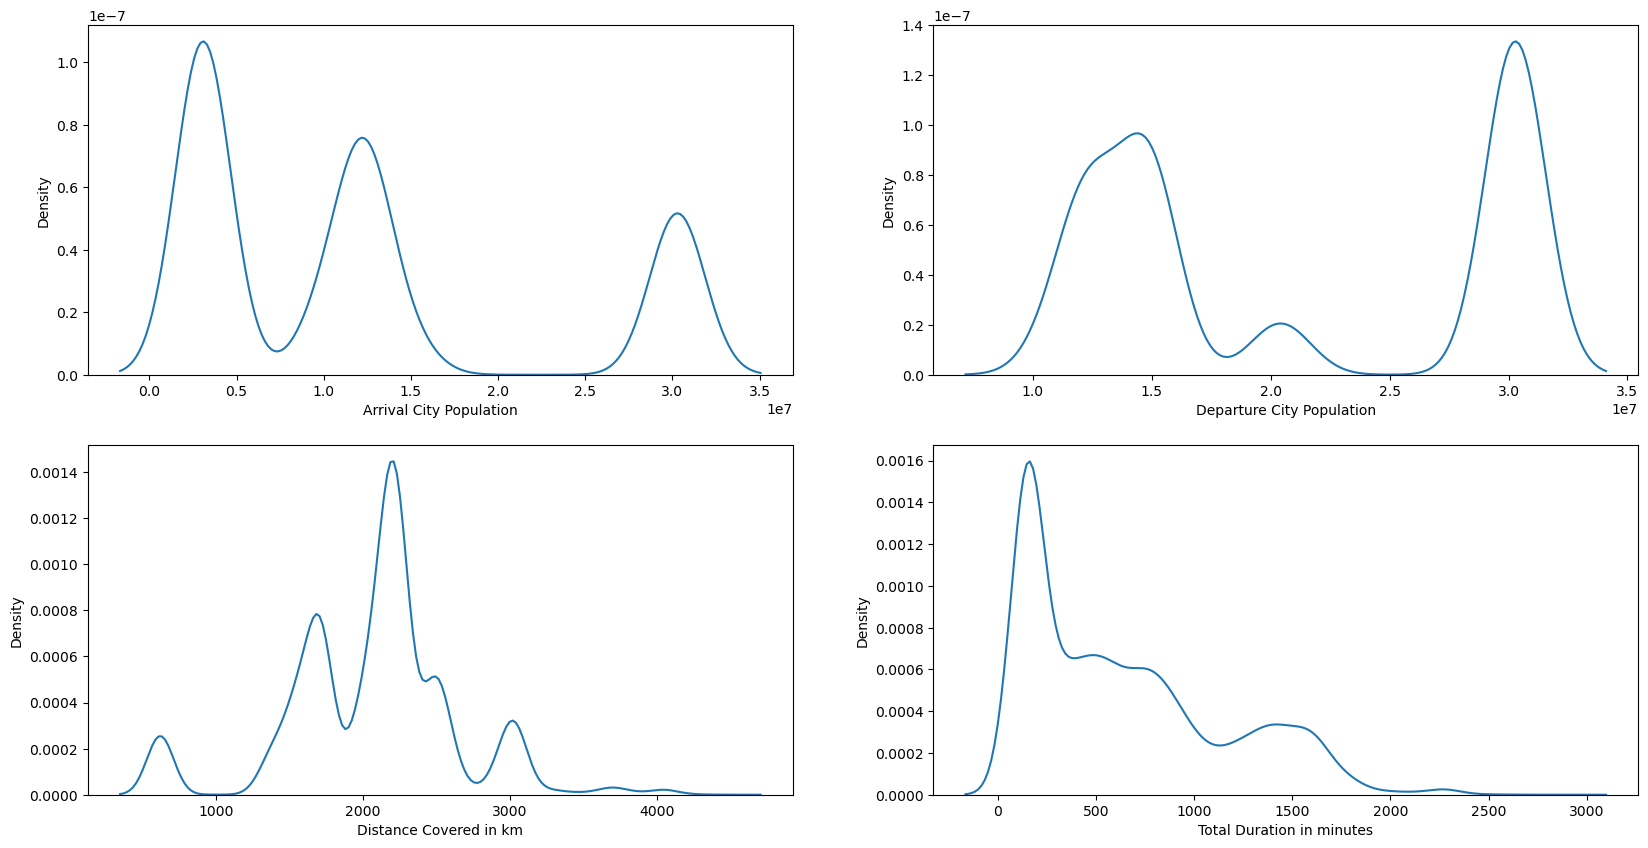

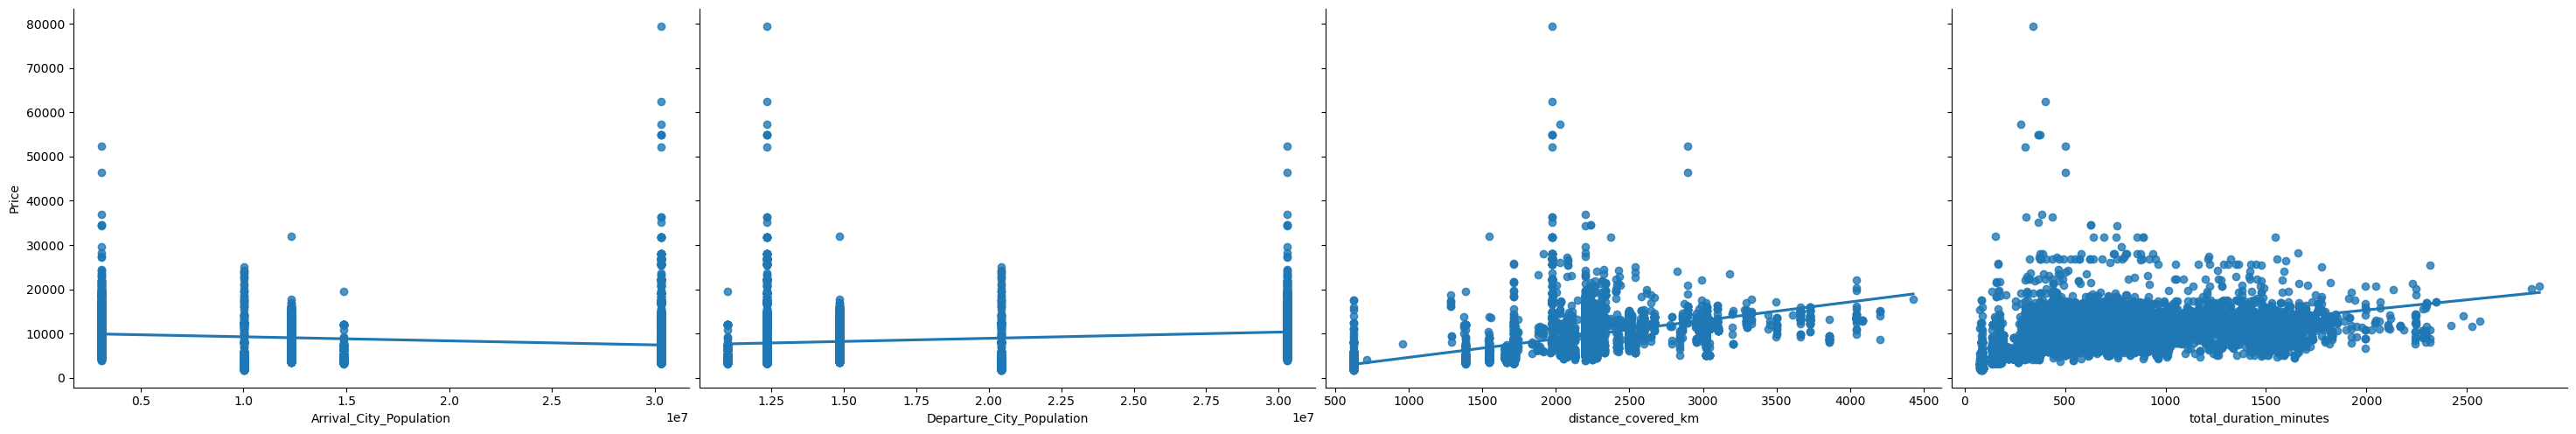

In [57]:
plt.figure(1,figsize=(20,10))
plt.subplot(221)
sns.kdeplot(data=df_delete_cols, x='Arrival_City_Population')
plt.xlabel('Arrival City Population')
plt.subplot(222)
sns.kdeplot(data=df_delete_cols, x='Departure_City_Population')
plt.xlabel('Departure City Population')
plt.subplot(223)
sns.kdeplot(data=df_delete_cols, x='distance_covered_km')
plt.xlabel('Distance Covered in km')
plt.subplot(224)
sns.kdeplot(data=df_delete_cols, x='total_duration_minutes')
plt.xlabel('Total Duration in minutes')

plt.show()

sns.pairplot(df_delete_cols,
             x_vars=["Arrival_City_Population","Departure_City_Population","distance_covered_km", "total_duration_minutes"],
             y_vars= "Price",kind="reg",
            height = 5, aspect = 1.5)


plt.show()


<h4>Feature Normalization</h4>

In [58]:
#View statistics about each column -- Feature normalization
df_delete_cols.describe()

#QUESTION: Should we normalize sin and cos to [0,1] since values belong to range [-1,1]

###COLUMNS TO BE NORMALIZED
# total_duration_minutes
# departure_airport_class
# arrival_airport_class
# distance_covered_km
# Additional_Info_Layovers
# num_stops
# Arrival_City_Population
# Departure_City_Population
# duration_hours
# duration_minutes

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler




In [59]:
df_x=df_delete_cols.drop(['Price'],axis=1)
df_y=df_delete_cols['Price']

print("x is\n",df_x)
print ("y is\n",df_y)



x is
        Airline_IndiGo  Airline_Air India  Airline_Jet Airways  Airline_SpiceJet  Airline_Multiple carriers  Airline_GoAir  Airline_Vistara  Airline_Air Asia  Airline_Vistara Premium economy  \
0                 1.0                0.0                  0.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
1                 0.0                1.0                  0.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
2                 0.0                0.0                  1.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
3                 1.0                0.0                  0.0               0.0                        0.0            0.0              0.0               0.0                              0.0   
4                 1.0        

p:value: 0.0


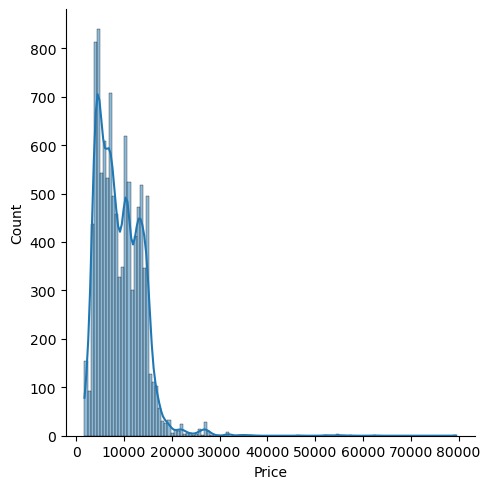

In [60]:
# We check the Distribution of the price, if it is actually follows the normal distribution. (p>=0.05)
import seaborn as sns
# distribution plot of the target variable
sns.displot(df_y, kde = True)
from scipy import stats
_, p = stats.normaltest(df_y)
print("p:value:",p)



In [61]:
# #Standardize/Normalize data using standard scaler
# scaler = StandardScaler()
# df_x = scaler.fit_transform(df_x)
# #
# # rscaler = RobustScaler().fit(df_x)
# # df_x = rscaler.fit_transform(df)

In [62]:
#Print scaled data
#print(df_x)
#df_x.describe()


0.0


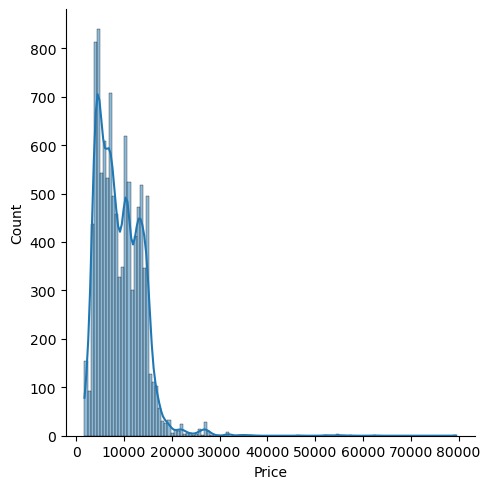

In [63]:
# We check the Distribution of the price, if it is actually follows the normal distribution. (p>=0.05)
import seaborn as sns
# distribution plot of the target variable
sns.displot(df_y, kde = True)
from scipy import stats
_, p = stats.normaltest (df_y)
print(p)




In [64]:
# Feature Importance using
import matplotlib.pyplot as plt

from sklearn.ensemble import ExtraTreesRegressor
# Build an estimator (forest of trees) and compute the feature
estimator =ExtraTreesRegressor(n_estimators =100, max_features = 13, random_state =0)
estimator.fit(df_x,df_y)
importances= estimator.feature_importances_

std = np.std([tree.feature_importances_ for tree in estimator.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize=(200,120))
plt.title("Feature importances")
plt.bar(range(df_x.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_x.shape[1]), indices)
plt.xlim([-1, df_x.shape[1]])

plt.savefig('vis\\feature_importance_extratrees_standardized.png')
plt.show()




In [65]:
#print columns sorted in order of importance
print(indices[1])
print(np.argsort(importances)[::-1])

# for index,lol in enumerate(importances):
#     print(f'{index}, {lol}')

column_list = df_x.columns.tolist()
for count, i in enumerate(indices):
    print(f"Rank:{count}, \tIndex:{i}, \tName: {column_list[i]}, \t\t Value: {importances[i]}")

2
[ 69   2  34 101  56  30   0   9  24  23  21  17   3  49  51  87  44  28
  48  46  47  52  19  53  50  45   1  54  39  40   4  42  37  33  36  31
  32  38  41  43  55  14  12  22  16  18  13   7   6  85  71  65   5  70
  25  61  35  74  76  99  73  15  20  93  86  67 100  82  84  60  89  59
  27  75  94  62  77  88  96  80  66  10  68  63  81  97   8  95  26  83
  90  98  72  11  78  29  79  91  92  64  57  58]
Rank:0, 	Index:69, 	Name: BOM, 		 Value: 0.1397832569827274
Rank:1, 	Index:2, 	Name: Airline_Jet Airways, 		 Value: 0.07874196640817138
Rank:2, 	Index:34, 	Name: num_stops, 		 Value: 0.0562419898779878
Rank:3, 	Index:101, 	Name: total_duration_minutes, 		 Value: 0.04422152083209466
Rank:4, 	Index:56, 	Name: distance_covered_km, 		 Value: 0.042469110720266365
Rank:5, 	Index:30, 	Name: duration_hours, 		 Value: 0.04190211388783797
Rank:6, 	Index:0, 	Name: Airline_IndiGo, 		 Value: 0.03185939273017435
Rank:7, 	Index:9, 	Name: Airline_Jet Airways Business, 		 Value: 0.030217105302

In [66]:
# featue selection ---- correlation matrix

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm as cm

sns.color_palette("rocket", as_cmap=True)

plt.figure(figsize=(200,120))
corr = df_delete_cols.corr( method='pearson')
cmap_= cm.get_cmap('rocket',30)
_, ax =plt.subplots(figsize = ( 200 , 120 ))
correlation_matrix = sns.heatmap(corr ,cmap = cmap_ , square=True, cbar_kws ={ 'shrink' : .9 }, ax=ax,
             annot = True, annot_kws = {'fontsize' : 12 }, xticklabels=corr.columns ,yticklabels=corr.columns)




C:\Users\panay\AppData\Local\Temp\ipykernel_13868\3498291156.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_= cm.get_cmap('rocket',30)


<Figure size 20000x12000 with 0 Axes>

In [67]:
#save the correlation matrix in the folder vis which will contain visualization graphs
correlation_matrix.figure.savefig("vis\\correlation_matrix_v1_standardized.png")

In [68]:
"""How to move forward?
We want to now add more features - such as population of destination city, found in excel file índian_cities_population.xslx,

We will also add a total km covered, which we will do by analyzing the route and calculating distance between airports.
"""

'How to move forward?\nWe want to now add more features - such as population of destination city, found in excel file índian_cities_population.xslx,\n\nWe will also add a total km covered, which we will do by analyzing the route and calculating distance between airports.\n'

In [69]:
"""Based on the above correlation matrix, we will make a dataframe for the
    that will produce a more comprehensive correlation matrix than the previous one
    
    We will remove columns that have to do with the Airline (encoded as one-hot encoding)
    and columns that have to do with the in-between route (encoded as one-hot encoding)
    """
#print(corr)
print(type(corr))
corr_copy = corr

print(corr.iloc[0][0])
column_list = corr_copy.columns.tolist()


#We will print column-pairs with a pearson correlation value of over |0.5| and whether is positive or negative
def print_related_columns(corr_matrix):
    CCC = 0
    for i in range(0, len(corr_matrix)):
        for j in range(0, i):
            val = corr_matrix.iloc[i][j]
            if abs(val) >= 0.4:
                symbolaki = str()
                if(val) > 0:
                    symbolaki = '+'
                else:
                    symbolaki = '-'
                print(f'{CCC}:\t{corr_matrix.index[i]}\t{symbolaki}\t{corr_matrix.columns[j]}')
                CCC = CCC+1
                
                       
    
print_related_columns(corr_copy)

<class 'pandas.core.frame.DataFrame'>
1.0
0:	Source_Delhi	+	Airline_Multiple carriers
1:	Source_Delhi	-	Source_Banglore
2:	Source_Delhi	-	Source_Kolkata
3:	Destination_New Delhi	+	Source_Banglore
4:	Destination_Banglore	+	Source_Kolkata
5:	Destination_Banglore	-	Source_Delhi
6:	Destination_Cochin	+	Airline_Multiple carriers
7:	Destination_Cochin	-	Source_Banglore
8:	Destination_Cochin	-	Source_Kolkata
9:	Destination_Cochin	+	Source_Delhi
10:	Destination_Cochin	-	Destination_Banglore
11:	Destination_Kolkata	+	Source_Chennai
12:	Destination_Delhi	+	Source_Banglore
13:	Destination_Hyderabad	+	Source_Mumbai
14:	Additional_Info_No Info	-	Airline_Jet Airways
15:	Additional_Info_In-flight meal not included	+	Airline_Jet Airways
16:	Additional_Info_In-flight meal not included	-	Additional_Info_No Info
17:	Additional_Info_No check-in baggage included	+	Airline_SpiceJet
18:	Additional_Info_Business class	+	Airline_Jet Airways Business
19:	Price	+	Airline_Jet Airways
20:	duration_hours	+	Price
21

Looking on the above snapshot of the correlation matrix, we made decisions about columns that would be dropped.
Based on lines 15-18 included, we have decided to remove all additional_info columns because: 1) No Additional_Info columns have a significant correlation (positive or negative) with the price, and 2) Some Additional_Info columns have significant correlation with the airline columns (meaning that specific info is found only in flights from specific airlines)

Some other information that we have discovered from the correlation matrix, is that the total distance covered is significantly correlated to the price of the flight, as well as the stops and duration (which makes logical sense).

In [70]:
for i in df_x.columns.tolist():
    print(i)

Airline_IndiGo
Airline_Air India
Airline_Jet Airways
Airline_SpiceJet
Airline_Multiple carriers
Airline_GoAir
Airline_Vistara
Airline_Air Asia
Airline_Vistara Premium economy
Airline_Jet Airways Business
Airline_Multiple carriers Premium economy
Airline_Trujet
Source_Banglore
Source_Kolkata
Source_Delhi
Source_Chennai
Source_Mumbai
Destination_New Delhi
Destination_Banglore
Destination_Cochin
Destination_Kolkata
Destination_Delhi
Destination_Hyderabad
Additional_Info_No Info
Additional_Info_In-flight meal not included
Additional_Info_No check-in baggage included
Additional_Info_1 Short layover
Additional_Info_Change airports
Additional_Info_Business class
Additional_Info_Red-eye flight
duration_hours
duration_minutes
Departure_City_Population
Arrival_City_Population
num_stops
Additional_Info_Layovers
dep_hour_sin
dep_hour_cos
arr_hour_sin
arr_hour_cos
dep_minute_sin
dep_minute_cos
arr_minute_sin
arr_minute_cos
dep_day_of_year_sin
dep_day_of_year_cos
arr_day_of_year_sin
arr_day_of_year_

In [71]:
#REMOVE COLUMNS AND SAVE THE DATAFRAME
# Additional_Info_No Info
# Additional_Info_In-flight meal not included
# Additional_Info_No check-in baggage included
# Additional_Info_1 Short layover
# Additional_Info_Change airports
# Additional_Info_Business class
# Additional_Info_Red-eye flight
# duration_hours
# duration_minutes
# Additional_Info_Layovers

df_feature_select = df_x.drop(['Additional_Info_No Info', 
                            'Additional_Info_In-flight meal not included',
                            'Additional_Info_No check-in baggage included',
                            'Additional_Info_1 Short layover',
                            'Additional_Info_Change airports',
                            'Additional_Info_Business class',
                            'Additional_Info_Red-eye flight',
                            'Additional_Info_Layovers',
                            'duration_hours',
                            'duration_minutes'], axis=1)

# saving the not scaled data to check them too.
df_not_scaled=df_feature_select


for i,dat in enumerate(df_feature_select.columns):
    print(i," ",dat)


0   Airline_IndiGo
1   Airline_Air India
2   Airline_Jet Airways
3   Airline_SpiceJet
4   Airline_Multiple carriers
5   Airline_GoAir
6   Airline_Vistara
7   Airline_Air Asia
8   Airline_Vistara Premium economy
9   Airline_Jet Airways Business
10   Airline_Multiple carriers Premium economy
11   Airline_Trujet
12   Source_Banglore
13   Source_Kolkata
14   Source_Delhi
15   Source_Chennai
16   Source_Mumbai
17   Destination_New Delhi
18   Destination_Banglore
19   Destination_Cochin
20   Destination_Kolkata
21   Destination_Delhi
22   Destination_Hyderabad
23   Departure_City_Population
24   Arrival_City_Population
25   num_stops
26   dep_hour_sin
27   dep_hour_cos
28   arr_hour_sin
29   arr_hour_cos
30   dep_minute_sin
31   dep_minute_cos
32   arr_minute_sin
33   arr_minute_cos
34   dep_day_of_year_sin
35   dep_day_of_year_cos
36   arr_day_of_year_sin
37   arr_day_of_year_cos
38   dep_day_of_month_sin
39   dep_day_of_month_cos
40   arr_day_of_month_sin
41   arr_day_of_month_cos
42   dep

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

#Standardize/Normalize data using standard scaler
scaler = StandardScaler()
df_feature_select = scaler.fit_transform(df_feature_select)


#
# rscaler = RobustScaler().fit(df_x)
# df_x = rscaler.fit_transform(df)

<h2>Feature Selection - Sequential Forward Selection</h2>

<h2>Feature Selection - Sequential Forward Selection for KNN and SVR</h2>

In [6]:
#conda install -c conda-forge mlxtend
# Example 1
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

##################################### KNN ############################################################################
regressor = "KNN"
#os.mkdir(f'vis\\{regressor}')

#declare parameters
neighbors = [5, 10, 15, 30, 50]
selected_features = 30
cross_validation = 10

best_sfs_knn = 0
best_score_knn = 0
for neighbor in neighbors:
    knn = KNeighborsRegressor(n_neighbors=neighbor)
    # Sequential Forward Selection
    sfs = SFS(knn, 
           k_features=selected_features, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=cross_validation)

    sfs = sfs.fit(df_feature_select, df_y)

    print(f'\nSequential Forward Selection (k={selected_features}):')
    print('Selected features:',sfs.k_feature_idx_)
    print('Prediction score:',sfs.k_score_)
    
    if(sfs.k_score_ > best_score_knn):
        best_sfs_knn = sfs

    # sfs = sfs.fit(X, y)

    fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(20,10) )

    plt.ylim([0.30, 1])
    plt.title(f'Sequential Forward Selection (w. StdDev) with K-Nearest Neighbors Regressor\nParameters: k={neighbor}, cv={cross_validation}')
    plt.grid()
    plt.savefig(f'vis\\{regressor}\SFS_{regressor}_{neighbor}_cv{cross_validation}.jpg')
    plt.show()    

#END OF LOOP -- KNN FEATURE SELECTION DONE
###############################################################################################################################

##################################### SVR  ###################################################################################
regressor = "SVR"
#os.mkdir(f'vis\\{regressor}')
Cs=[0.1, 1, 10, 100]
gammas = [1, 0.1, 0.01, 0.001]
kernels = ['rbf', 'poly', 'sigmoid']

best_sfs_svr = 0
best_score_svr = 0
for svrC in Cs:
    for svrgamma in gammas:
        for svrkernel in kernels:
            svr = SVR(C=svrC, gamma=svrgamma, kernel=svrkernel)
            sfs = SFS(svr,
                     k_features = selected_features,
                     forward=True,
                     floating=False,
                     verbose=2,
                     scoring='r2',
                     cv=cross_validation)
            sfs = sfs.fit(df_feature_select, df_y)
            
            if(sfs.k_score_ > best_score_svr):
                best_sfs_svr = sfs
            
            fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(20,10) )

            plt.ylim([0.30, 1])
            plt.title(f'Sequential Forward Selection (w. StdDev) with Support Vector Machine Regressor\nParameters: C={svrC}, gamma={svrgamma}, kernel={svrkernel}, cv={cross_validation}')
            plt.grid()
            plt.savefig(f'vis\\{regressor}\SFS_{regressor}_{svrC}_{svrgamma}_{svrkernel}_cv{cross_validation}.jpg')
            plt.show()  
            
    

NameError: name 'df_feature_select' is not defined

<h2>Feature Selection - Sequential Forward Selection for Decision Tree and Random Forest</h2>

In [69]:
##################################### Decision Tree  ############################################################################

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
    
from sklearn.tree import DecisionTreeRegressor
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

regressor = "Decision Tree"

#declare parameters
# max_depth_=None
# default is 2
min_samples_split_=2
# max_features_= 10
#criterion{“squared_error”, “friedman_mse”, “absolute_error”, “poisson”}, default=”squared_error”
criterion_='squared_error'


# forward selection parameters for model
selected_features = 30
cross_validation = 10

decisionTree = DecisionTreeRegressor( min_samples_split=min_samples_split_,
                                    criterion=criterion_
                                    )



from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Sequential Forward Selection
sfs = SFS(decisionTree, 
           k_features=selected_features, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=cross_validation)

sfs = sfs.fit(df_feature_select, df_y)


print('\nSequential Forward Selection (k=5):')
print('Selected features:',sfs.k_feature_idx_)
print('Prediction score:',sfs.k_score_)

#print all combinations of subsets -- might be a lot 
print('All combinations\n',sfs.subsets_)


#os.mkdir(f'vis\\{regressor}')

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(20,10) )


plt.ylim([0.30, 1])
plt.title(f'Sequential Forward Selection (w.StdDev) with Decision Tree\nParameters: min_samples_split={min_samples_split_} criterion={criterion_} cv={cross_validation}')
plt.grid()
# plt.savefig(f'{regressor}-SFS_max-depth={max_depth_}_min_samples_split={min_samples_split_}_criterion={criterion_}_cv={cross_validation}.jpg')
plt.savefig(f'{regressor}-SFS_min_samples_split={min_samples_split_}_criterion={criterion_}_cv={cross_validation}.jpg')

plt.show()
##############################################################################################################################

######################################## RANDOM FOREST ###################################################################
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

from sklearn.ensemble import RandomForestRegressor
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

regressor = "Random Forest"

#declare parameters for model
n_estimators_=500

#criterion{“squared_error”, “friedman_mse”, “absolute_error”, “poisson”}, default=”squared_error”
criterion_='squared_error'

# default=None
# max_depth_=3

# default is 2
min_samples_split_=2



# forward selection parameters
selected_features = 15
cross_validation = 5
decisionTree = RandomForestRegressor(n_estimators=n_estimators_, criterion=criterion_, min_samples_split=min_samples_split_
                                    )



from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
sfs = SFS(decisionTree, 
           k_features=selected_features, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=cross_validation)

sfs = sfs.fit(df_feature_select, df_y)


print('\nSequential Forward Selection (k=5):')
print('Selected features:',sfs.k_feature_idx_)
print('Prediction score:',sfs.k_score_)

#print all combinations of subsets -- might be a lot 
print('All combinations\n',sfs.subsets_)


#os.mkdir(f'vis\\{regressor}')

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(20,10) )


plt.ylim([0.30, 1])
plt.title(f'Sequential Forward Selection (w. StdDev) with Random Forest\nParameters:n_estimators={n_estimators_}, criterion={criterion_}, min_samples_split={min_samples_split_}, cv={cross_validation}')
plt.grid()
plt.savefig(f'{regressor}-SFS_n_estimators={n_estimators_}, criterion={criterion_}, min_samples_split={min_samples_split_}, cv={cross_validation}.jpg')
plt.show()

<h2>Feature Selection - Sequential Forward Selection for ADABOOST and GRADIENT BOOSTING</h2>

In [70]:
#conda install -c conda-forge mlxtend
############################### ADA BOOST ####################################################################################
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html
from sklearn.ensemble import AdaBoostRegressor
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

regressor = "AdaBoostRegressor"
#declare parameters
selected_features = 30
cross_validation = 10
n_estimators_=400
# default linear
loss_='linear'
ada = AdaBoostRegressor(n_estimators=n_estimators_, loss=loss_)



from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Sequential Forward Selection
sfs = SFS(ada, 
           k_features=selected_features, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='r2',
           cv=cross_validation)

sfs = sfs.fit(df_feature_select, df_y)

print('\nSequential Forward Selection (k=5):')
print('Selected features:',sfs.k_feature_idx_)
print('Prediction score:',sfs.k_score_)

#print all combinations of subsets -- might be a lot 
print('All combinations\n',sfs.subsets_)


#os.mkdir(f'vis\\{regressor}')

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(20,10) )


plt.ylim([0.30, 1])
plt.title(f'Sequential Forward Selection (w.StdDev) with AdaBoostRegressor \nParameters: n_estimators={n_estimators_} loss={loss_} cv={cross_validation}')
plt.grid()
# plt.savefig(f'{regressor}-SFS_max-depth={max_depth_}_min_samples_split={min_samples_split_}_criterion={criterion_}_cv={cross_validation}.jpg')
plt.savefig(f'{regressor}-SFS_n_estimators={n_estimators_}_loss={loss_}_cv={cross_validation}.jpg')

plt.show()
##############################################################################################################################

############################### Gradient Boosting   #################################################################################
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.ensemble import GradientBoostingRegressor

regressor = "GradientBoosting"
#os.mkdir(f'vis\\{regressor}')

best_sfs_gradientboosting = 0
best_score_gradientboosting = 0
selected_features = 30
cross_validation = 10

#parameters for GradientBoostingRegressor
max_features_list = ['auto', 'log2', 'sqrt']
max_depths_list = [3, 5, 7]

for feature in max_features_list:
    for depth in max_depths_list:
        gradientboosting = GradientBoostingRegressor(max_features = feature,
                                                    max_depth = depth)
        sfs = SFS(gradientboosting,
                     k_features = selected_features,
                     forward=True,
                     floating=False,
                     verbose=2,
                     scoring='r2',
                     cv=cross_validation)
        sfs = sfs.fit(df_feature_select, df_y)
            
        if(sfs.k_score_ > best_score_gradientboosting):
            best_sfs_gradientboosting = sfs
            
        fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(20,10) )

        plt.ylim([0.30, 1])
        plt.title(f'Sequential Forward Selection (w. StdDev) with Gradient Boosting Regressor\nParameters: max_features={feature}, max_depth={depth}, cv={cross_validation}')
        plt.grid()
        plt.savefig(f'vis\\{regressor}\SFS_{regressor}_{feature}_{depth}_cv{cross_validation}.jpg')
        plt.show()  

#gradientboosting = GradientBoostingRegressor(max_features = )



In [76]:
best_sfs_gradientboosting.subsets_
# these are the best features in the best algorithm we run.
"""
cv_scores': array([0.87014278, 0.84845608, 0.81592437, 0.86309378, 0.86279008,
         0.86616442, 0.84068547, 0.8602221 , 0.83650731, 0.85628727]),
  'avg_score': 0.8520273668642944,
  'feature_names': 
  ('0' Airline_IndiGo,
   '1' Airline_Air India,
   '2' Airline_Jet Airways,
   '4' Airline_Multiple carriers,
   '6' Airline_Vistara,
   '9' Airline_Jet Airways Business,
   '13' Source_Kolkata ,
   '16' Source_Mumbai,
   '17' Destination_New Delhi,
   '23' Departure_City_Population,
   '24' Arrival_City_Population,
   '25' num_stops,
   '26' dep_hour_sin,
   '31' dep_minute_cos,
   '33' arr_minute_cos,
   '38' dep_day_of_month_sin,
   '39' dep_day_of_month_cos,
   '40' arr_day_of_month_sin,
   '42' dep_day_of_week_sin,
   '43' dep_day_of_week_cos,
   '44' arr_day_of_week_sin,
   '45' arr_day_of_week_cos,
   '46' distance_covered_km,
   '53' DED,
   '55' DEL,
   '56' ISK,
   '57' NDC,
   '76' RPR,
   '90' STV,
   '91' total_duration_minutes
   )}}
"""

{1: {'feature_idx': (46,),
  'cv_scores': array([0.56009019, 0.55135271, 0.49073866, 0.59748611, 0.60125697,
         0.53797642, 0.55473046, 0.55372219, 0.53935656, 0.51199544]),
  'avg_score': 0.5498705719935856,
  'feature_names': ('46',)},
 2: {'feature_idx': (40, 46),
  'cv_scores': array([0.7016206 , 0.66587746, 0.61824364, 0.69784617, 0.69783003,
         0.71124574, 0.66106169, 0.71496142, 0.68471295, 0.61932244]),
  'avg_score': 0.6772722152604937,
  'feature_names': ('40', '46')},
 3: {'feature_idx': (2, 40, 46),
  'cv_scores': array([0.76188962, 0.7135518 , 0.69841918, 0.76597513, 0.73683312,
         0.78101833, 0.68956538, 0.72793248, 0.7315114 , 0.61004641]),
  'avg_score': 0.7216742833205771,
  'feature_names': ('2', '40', '46')},
 4: {'feature_idx': (2, 40, 44, 46),
  'cv_scores': array([0.81256184, 0.75468549, 0.7342962 , 0.79812545, 0.78423349,
         0.82122627, 0.74316839, 0.81241377, 0.77321893, 0.66956774]),
  'avg_score': 0.7703497565497652,
  'feature_names': 

In [117]:
print(best_score_gradientboosting)
sfs.subsets_

0


{1: {'feature_idx': (46,),
  'cv_scores': array([0.56009019, 0.55135271, 0.49073866, 0.59748611, 0.60125697,
         0.53797642, 0.55473046, 0.55372219, 0.53935656, 0.51199544]),
  'avg_score': 0.5498705719935856,
  'feature_names': ('46',)},
 2: {'feature_idx': (38, 46),
  'cv_scores': array([0.71540651, 0.65400773, 0.62723191, 0.68542341, 0.71575689,
         0.69737521, 0.65029439, 0.72282631, 0.68464175, 0.61889727]),
  'avg_score': 0.6771861352612409,
  'feature_names': ('38', '46')},
 3: {'feature_idx': (2, 38, 46),
  'cv_scores': array([0.77055235, 0.69784186, 0.70365837, 0.74844164, 0.76874769,
         0.75424271, 0.68308711, 0.76773496, 0.73106466, 0.62260767]),
  'avg_score': 0.7247979038009061,
  'feature_names': ('2', '38', '46')},
 4: {'feature_idx': (2, 38, 42, 46),
  'cv_scores': array([0.81991615, 0.75250854, 0.7291514 , 0.78621089, 0.80823397,
         0.79741743, 0.76913823, 0.80849273, 0.76980627, 0.67521169]),
  'avg_score': 0.7716087295166796,
  'feature_names': 

In [89]:
# keep the most important features from X dataset that maximize the accuracy
# Generate (transform) the new subsets based on the selected features
X_sfs = best_sfs_gradientboosting.transform(df_feature_select)
print(X_sfs)
print(X_sfs.shape)

[[ 2.05015058 -0.44278513 -0.75053033 ... -0.169697   -0.00967596
  -0.93160111]
 [-0.48776905  2.25843176 -0.75053033 ... -0.169697   -0.00967596
  -0.39002765]
 [-0.48776905 -0.44278513  1.3323912  ... -0.169697   -0.00967596
   0.97867618]
 ...
 [-0.48776905 -0.44278513  1.3323912  ... -0.169697   -0.00967596
  -0.91190753]
 [-0.48776905 -0.44278513 -0.75053033 ... -0.169697   -0.00967596
  -0.95129469]
 [-0.48776905  2.25843176 -0.75053033 ... -0.169697   -0.00967596
  -0.28171296]]
(10682, 30)


In [74]:
# IF i do not want to run SFS
#scaled data is located in df_feature_select

temp_df=pd.DataFrame(df_feature_select)

#Select the best performing features based on SFS -- manually because sfs was ran before
X_sfs=temp_df.iloc[:,[0,1,2,4,6,9,13,16,17,23,24,25,26,31,33,38,39,40,42,43,44,45,46,53,55,56,57,76,90,91]]
print(X_sfs)


             0         1         2         4         6         9         13        16        17        23        24        25        26        31        33        38        39        40        42  \
0      2.050151 -0.442785 -0.750530 -0.355078 -0.216673 -0.023707 -0.606266 -0.264206  3.234405 -1.082357  1.797507 -1.220666 -0.372851 -0.888080  0.723457 -1.440400  0.234031 -1.371145 -0.048079   
1     -0.487769  2.258432 -0.750530 -0.355078 -0.216673 -0.023707  1.649441 -0.264206 -0.309176 -0.771474  0.028779  1.741432  1.271095  0.562970  0.024318  0.183647  1.456597  0.186620  1.343740   
2     -0.487769 -0.442785  1.332391 -0.355078 -0.216673 -0.023707 -0.606266 -0.264206 -0.309176  1.130740 -0.881407  1.741432  0.813015 -1.356702 -1.152920  1.207077 -0.445746  1.095700 -0.048079   
3      2.050151 -0.442785 -0.750530 -0.355078 -0.216673 -0.023707  1.649441 -0.264206 -0.309176 -0.771474  0.028779  0.260383 -1.306512  0.939472 -1.305053  0.798004 -1.109720  0.802141 -0.048079   
4    

In [75]:
# We save the dataset of the final dataset- features used in Final-Dataset.csv

df_to_save=pd.concat([X_sfs,df_y], axis=1, ignore_index=True)
df_to_save.to_csv("Final-Dataset-Scaled.csv")



<h3>Creating the Grid</h3>

In [ ]:
# keep the most important features from X dataset that maximize the accuracy
# Generate (transform) the new subsets based on the selected features
#X_sfs = sfs_range.transform(df_feature_select)

In [76]:
# Split X_sfs and y datasets into: training dataset - 80%, test - 20%; set random_state param to 0
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sfs, df_y, random_state = 0, test_size = 0.20)

In [77]:
# Define the metric machine hack wants us to use
#1 - np.sqrt(np.square(np.log10(y_pred +1) - np.log10(y_true +1)).mean())
def metric_rmsle(y_test, y_pred):
    if len(y_test) != len(y_pred):
        print("Mistake")
        return
    
    machine_hack_score = 1 - np.sqrt(np.square(np.log10(y_pred+1) - np.log10(y_test + 1)).mean())
    
    return machine_hack_score

<h3>Creating the Grid for models: Gradient Boosting, KNN,Decision Tree, Random Forest and Extra Trees and Extreme Gradient Boosting</h3>

In [104]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

###### Documentation for the parameters we tried and changed #################################################################
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html
###############################################################################################################################

# perform grid search CV on a number of Regressors to find the best along with the set of
# its best parameters

# names list is used for printing results purposes
names = [
         "Gradient Boosting Regression",
         "K Nearest Neighbors Regression",
        "Decision Tree Regression",
         "Random Forest Regression",
         "Extra Trees Regression",
     "Extreme Gradient Boosting Regression (XGBoost)"
]

regressors = [
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    ExtraTreesRegressor(),
    XGBRegressor()
]

parameters = [
              {'learning_rate': [0.01, 0.1, 0.5], 'max_depth':[7, None],
               'max_features': ["auto", "log2"], 'subsample': [0.8, 0.9, 1.0],'n_estimators': [100, 500]},
              {'n_neighbors': [2, 5, 10]} ,
              {'criterion': ['squared_error', 'friedman_mse', 'poisson'], 'max_depth': [2,4,6,10, 100, None]},
              {'n_estimators': [20,100, 500, 750,1000, 1500,2000,2500,5000], 'max_features': ['auto', 'sqrt', 'log2', None], 
               'max_depth' : [2,3,4,10, None], 'criterion' :['squared_error', 'poisson', 'friedman_mse']},
              {'n_estimators': [30, 200, 500, 750], 'max_features': ['auto', 'sqrt', 'log2', None],
               'max_depth' : [2,3,4, 20,40,80, None], 'criterion' : ['squared_error', 'poisson', 'friedman_mse']},
            {'lambda': [1, 3, 5], 'alpha': [0, 1, 2], 'max_depth':[3,5,7,9], 
                'learning_rate':[0.1, 0.2 ,0.3, 0.4]}
]

# print results
for name, regressor, params in zip(names, regressors, parameters):
    gs = GridSearchCV(regressor, param_grid=params, scoring='r2', n_jobs=4)
    gs.fit(X_train, y_train)
    
    #Because something below isn't working
    y_pred = gs.predict(X_test)
    print(f"R2-Score:{r2_score(y_pred, y_test)}")
    print(f"RMSLE (Machine-Hack metric):{metric_rmsle(y_pred, y_test)}")
    
    print("{} score: {} - best params: {}".format(name, gs.best_score_, gs.best_params_))

R2-Score:0.8045531099699903
RMSLE (Machine-Hack metric):0.9234161702009416
Gradient Boosting Regression score: 0.8391842024510539 - best params: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 100, 'subsample': 1.0}
R2-Score:0.6687661597411674
RMSLE (Machine-Hack metric):0.8987924436746864
K Nearest Neighbors Regression score: 0.7460535348606255 - best params: {'n_neighbors': 5}


In [ ]:

best_estimator = gs.best_estimator_
best_score = gs.best_score_
best_parameters = gs.best_params_

print(f"Best Estimator:{best_estimator}\nBest Parameters:{best_parameters}\nBest Score:{best_score}\n")

<h2>Choosing the best Regressor from the GridSearch</h2>


In [84]:
"""
The best regressor according to the results is Gradient Boosting Regressor with
parameters
Gradient Boosting Regression r2-score: 0.8391842024510539 
- best params: {'learning_rate': 0.1, 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 100, 'subsample': 1.0}
"""
from sklearn.ensemble import GradientBoostingRegressor

# 1.0 is the auto --python issue
GBR = GradientBoostingRegressor(learning_rate= 0.1, max_depth= 7, max_features= 1.0, n_estimators= 100, subsample= 1.0)



In [93]:
from sklearn.metrics import r2_score

#Train the model
GBR = GBR.fit(X_train, y_train)
#Predict on unseen data
y_predict = GBR.predict(X_test)

#Evaluate predictions using both r2-score and the rmsle metric machine hack wants.
print(r2_score(y_predict, y_test))
print(metric_rmsle(y_predict, y_test))

AttributeError: 'GradientBoostingRegressor' object has no attribute 'save_model'

<h3>Results: An RMSLE score of 0.923 puts us in the top 300 contestants and there is only 3% difference from the first 20.</h3>

<h3>Now we will train our model with cross validation so that we can achieve a higher score and a more trusted result</h3>

In [86]:
#Making our own scorer function that machineHack wants
from sklearn.metrics import make_scorer

def rmsle(y_true, y_pred):
    return 1 - np.sqrt(np.square(np.log10(y_pred+1) - np.log10(y_true + 1)).mean())

rmsle_scorer = make_scorer(rmsle, greater_is_better=True)

In [87]:
# Cross Validation to verify our previous results
from sklearn.model_selection import cross_val_score
CV_rmsle = np.mean(cross_val_score(GBR, X_train, y_train, cv = 10 ,scoring = rmsle_scorer ))
#CV_RMSE = np.sqrt(CV_MSE)
print("Validated Mean Squared Error: ", CV_rmsle)
#print("Validated Root Mean Squared Error: ", CV_RMSE)


Validated Mean Squared Error:  0.9223395217728779


In [ ]:
#Save the above model
XGB.save_model("XGBoost_standardized.json")

<h3>Results: An RMSLE score of 0.923 with Cross Validation</h3>

<h3>Now we run with UNSCALED data</h3>

<p>Running SFS on unscaled data, only for gradient boosting (Which was the best performing algorithm overall)</p>


In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from sklearn.ensemble import GradientBoostingRegressor

regressor = "GradientBoosting"
#os.mkdir(f'vis\\{regressor}')

best_sfs_gradientboosting = 0
best_score_gradientboosting = 0
selected_features = 50
cross_validation = 5

#parameters for GradientBoostingRegressor
#max_features_list = ['auto', 'log2', 'sqrt'] #best perforing was auto
#max_depths_list = [3, 5, 7] #Best performing was 7

gradientboosting = GradientBoostingRegressor(max_features = 'auto',
                                                    max_depth = 7)
sfs = SFS(gradientboosting,
        k_features = selected_features,
        forward=True,
        floating=False,
        verbose=2,
        scoring='r2',
        cv=cross_validation,
        n_jobs = 6)
sfs = sfs.fit(df_not_scaled, df_y)
            
if(sfs.k_score_ > best_score_gradientboosting):
    best_score_gradientboosting = sfs.k_score_
    best_sfs_gradientboosting = sfs
            
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(20,10) )

plt.ylim([0.30, 1])
plt.title(f'Sequential Forward Selection (unscaled_data) (w. StdDev) with Gradient Boosting Regressor\nParameters: max_features={feature}, max_depth={depth}, cv={cross_validation}')
plt.grid()
plt.savefig(f'vis\\{regressor}\SFS_unscaled_{regressor}_auto_7_cv{cross_validation}.jpg')
plt.show()  

#gradientboosting = GradientBoostingRegressor(max_features = )



In [ ]:
if(sfs.k_score_ > best_score_gradientboosting):
    best_score_gradientboosting = sfs.k_score_
    best_sfs_gradientboosting = sfs
            
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev', figsize=(20,10) )

plt.ylim([0.30, 1])
plt.title(f'Sequential Forward Selection (unscaled_data) (w. StdDev) with Gradient Boosting Regressor\nParameters: max_features=auto, max_depth=7, cv={cross_validation}')
plt.grid()
plt.savefig(f'vis\\{regressor}\SFS_unscaled_{regressor}_auto_7_cv{cross_validation}.jpg')
plt.show()  

#gradientboosting = GradientBoostingRegressor(max_features = )



In [ ]:
best_sfs_gradientboosting.subsets_


In [88]:
"""
In order not to repeat SFS, the best features are
'Airline_IndiGo',
   'Airline_Air India',
   'Airline_Jet Airways',
   'Airline_Multiple carriers',
   'Airline_Vistara',
   'Airline_Jet Airways Business',
   'Airline_Multiple carriers Premium economy',
   'Source_Banglore',
   'Destination_Cochin',
   'Destination_Kolkata',
   'Departure_City_Population',
   'Arrival_City_Population',
   'dep_hour_cos',
   'dep_minute_sin',
   'dep_minute_cos',
   'arr_minute_cos',
   'dep_day_of_month_sin',
   'arr_day_of_month_sin',
   'dep_day_of_week_sin',
   'dep_day_of_week_cos',
   'arr_day_of_week_sin',
   'arr_day_of_week_cos',
   'distance_covered_km',
   'departure_airport_class',
   'arrival_airport_class',
   'HYD',
   'JLR',
   'VGA',
   'PNQ',
   'COK',
   'STV',
   'RPR',
   'IXB',
   'NDC',
   'BLR',
   'total_duration_minutes')}
"""
# No need for forward selection

X_sfs = df_not_scaled.loc[:, [
    'Airline_IndiGo',
    'Airline_Air India',
    'Airline_Jet Airways',
    'Airline_Multiple carriers',
    'Airline_Vistara',
    'Airline_Jet Airways Business',
    'Airline_Multiple carriers Premium economy',
    'Source_Banglore',
    'Destination_Cochin',
    'Destination_Kolkata',
    'Departure_City_Population',
    'Arrival_City_Population',
    'dep_hour_cos',
    'dep_minute_sin',
    'dep_minute_cos',
    'arr_minute_cos',
    'dep_day_of_month_sin',
    'arr_day_of_month_sin',
    'dep_day_of_week_sin',
    'dep_day_of_week_cos',
    'arr_day_of_week_sin',
    'arr_day_of_week_cos',
    'distance_covered_km',
    'departure_airport_class',
    'arrival_airport_class',
    'HYD',
    'JLR',
    'VGA',
    'PNQ',
    'COK',
    'STV',
    'RPR',
    'IXB',
    'NDC',
    'BLR',
    'total_duration_minutes']]

X_sfs.to_csv('Final-Dataset-Unscaled.csv', index=False)


In [89]:
from sklearn.model_selection import train_test_split
# Split X_sfs and y datasets into: training dataset - 80%, test - 20%; set random_state param to 0
X_train, X_test, y_train, y_test = train_test_split(X_sfs, df_y, random_state = 0, test_size = 0.20)


<h3>Since Gradient Boosting was our best performer, we will try XGBoost (Extreme Gradient Boosting) which can achieve better results and generalizes better</h3>


In [91]:
from xgboost import XGBRegressor


<h3>Hyperparameter Tuning for 3 models</h3>


In [ ]:
from sklearn.ensemble import RandomForestRegressor
# perform grid search CV on a number of classifiers to find the best along with the set of
# its best parameters

# names list is used for printing results purposes
names = [
        "Gradient Boosting Regression",
        "Extreme Gradient Boosting Regression (XGBoost)",
        "Random Forest Regression"
]

regressors = [
    GradientBoostingRegressor(),
    XGBRegressor(),
    RandomForestRegressor()
]

parameters = [
            {'learning_rate': [0.05, 0.1, 0.15, 0.2], 'max_depth':[6, 7, 8, 15],
                'max_features': ["auto"], 'min_samples_leaf': [1, 3, 5, 7],
                'n_estimators': [100, 200, 400]},
            {'lambda': [1, 3, 5], 'alpha': [0, 1, 2], 'max_depth':[3,5,7,9], 
                'learning_rate':[0.1, 0.2 ,0.3, 0.4]},
            {'n_estimators': [20,100, 500, 750,1000, 1500,2000,2500,5000], 'max_features': ['auto', 'sqrt', 'log2', None], 
                'max_depth' : [2,3,4,10, None], 'criterion' :['squared_error', 'poisson', 'friedman_mse']}
]

# print results
for name, regressor, params in zip(names, regressors, parameters):
    gs = GridSearchCV(regressor, param_grid=params, scoring='r2', n_jobs=4)
    gs.fit(X_train, y_train)
    
    #Because something below isn't working
    y_pred = gs.predict(X_test)
    print(f"R2-Score:{r2_score(y_pred, y_test)}")
    print(f"RMSLE (Machine-Hack metric):{metric_rmsle(y_pred, y_test)}")
    
    print("{} score: {} - best params: {}".format(name, gs.best_score_, gs.best_params_))


In [94]:
XGB = XGBRegressor(reg_alpha=0, reg_lambda=5, learning_rate=0.1, max_depth=9)
XGB_rmsle = np.mean(cross_val_score(XGB, X_train, y_train, cv=10, scoring = rmsle_scorer))
print("Validated Root Mean Squared Logarithmic Error", XGB_rmsle)




Validated Root Mean Squared Logarithmic Error 0.9229275533937507


In [95]:
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)
print(metric_rmsle(y_pred,y_test))

0.9235556052445506


In [96]:
#Save the best performing model for prediction.
XGB.save_model("XGBoost_standardized.json")